In [74]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [ ]:
area_pre_feature_selection = pd.read_csv('../../data/pre_training/area_pre_feature_selection.csv')
district_pre_feature_selection = pd.read_csv('../../data/pre_training/district_pre_feature_selection.csv')

In [ ]:
area_features = area_pre_feature_selection.drop('area_crimes_this_hour', axis=1)
district_features = district_pre_feature_selection.drop('district_crimes_this_hour', axis=1)

area_target = area_pre_feature_selection[['year', 'area_crimes_this_hour']]
district_target = district_pre_feature_selection[['year', 'district_crimes_this_hour']]

In [ ]:
# break the area dataset into testing and training datasets
area_feature_training_data = area_features[area_features['year'] < 2020].reset_index(drop=True)
area_feature_testing_data = area_features[area_features['year'] == 2020].reset_index(drop=True)

area_target_training_data = area_target[area_target['year'] < 2020].reset_index(drop=True)
area_target_testing_data = area_target[area_target['year'] == 2020].reset_index(drop=True)

In [ ]:
# break the district dataset into testing and training datasets
district_feature_training_data = district_features[district_features['year'] < 2020].reset_index(drop=True)
district_feature_testing_data = district_features[district_features['year'] == 2020].reset_index(drop=True)

district_target_training_data = district_target[district_target['year'] < 2020].reset_index(drop=True)
district_target_testing_data = district_target[district_target['year'] == 2020].reset_index(drop=True)

In [ ]:
area_target_training_data = area_target_training_data.drop('year', axis=1)
area_target_testing_data = area_target_testing_data.drop('year', axis=1)
district_target_training_data = district_target_training_data.drop('year', axis=1)
district_target_testing_data = district_target_testing_data.drop('year', axis=1)

In [ ]:
rf_area_feature_training_data = area_feature_training_data.drop('date_hour', axis=1)
rf_area_feature_testing_data = area_feature_testing_data.drop('date_hour', axis=1)

rf_district_feature_training_data = district_feature_training_data.drop('date_hour', axis=1)
rf_district_feature_testing_data = district_feature_testing_data.drop('date_hour', axis=1)

In [ ]:
# target encoding of district/area columns
area_means = area_pre_feature_selection.groupby('area_id')['area_crimes_this_hour'].mean()
district_means = district_pre_feature_selection.groupby('district')['district_crimes_this_hour'].mean()

rf_area_feature_training_data['area_id_target_encoded'] = rf_area_feature_training_data['area_id'].map(area_means)
rf_area_feature_testing_data['area_id_target_encoded'] = rf_area_feature_testing_data['area_id'].map(area_means)

rf_district_feature_training_data['district_target_encoded'] = rf_district_feature_training_data['district'].map(district_means)
rf_district_feature_testing_data['district_target_encoded'] = rf_district_feature_testing_data['district'].map(district_means)

In [ ]:
# frequency encoding of district/area columns
area_freq = area_pre_feature_selection['area_id'].value_counts() / len(area_pre_feature_selection)
district_freq = district_pre_feature_selection['district'].value_counts() / len(district_pre_feature_selection)

rf_area_feature_training_data['area_id_freq_encoded'] = rf_area_feature_training_data['area_id'].map(area_freq)
rf_area_feature_testing_data['area_id_freq_encoded'] = rf_area_feature_testing_data['area_id'].map(area_freq)

rf_district_feature_training_data['district_freq_encoded'] = rf_district_feature_training_data['district'].map(district_freq)
rf_district_feature_testing_data['district_freq_encoded'] = rf_district_feature_testing_data['district'].map(district_freq)

In [ ]:
rf_area_feature_training_data.drop('area_id', axis=1, inplace=True)
rf_area_feature_testing_data.drop('area_id', axis=1, inplace=True)

rf_district_feature_training_data.drop('district', axis=1, inplace=True)
rf_district_feature_testing_data.drop('district', axis=1, inplace=True)

In [ ]:
def patch_datatypes(df):
    float_cols = df.select_dtypes(include=['float64']).columns
    df[float_cols] = df[float_cols].astype(np.float32)

    int_cols = df.select_dtypes(include=['int64']).columns
    df[int_cols] = df[int_cols].astype(np.int32)    
      
    return df

In [ ]:
rf_area_feature_training_data = patch_datatypes(rf_area_feature_training_data)

In [ ]:
rf_area_feature_testing_data = patch_datatypes(rf_area_feature_testing_data)

In [ ]:
rf_district_feature_training_data = patch_datatypes(rf_district_feature_training_data)

In [ ]:
rf_district_feature_testing_data = patch_datatypes(rf_district_feature_testing_data)

##### Stratifying Datasets to Create a Random Sample

In [ ]:
rf_area_training_combined = pd.concat([rf_area_feature_training_data, area_target_training_data], axis=1)
rf_district_training_combined = pd.concat([rf_district_feature_training_data, district_target_training_data], axis=1)

In [17]:
rf_area_stratified_training_sample, _ = train_test_split(
    rf_area_training_combined, 
    stratify = rf_area_training_combined[['area_id_target_encoded']], 
    train_size = 0.3, 
    random_state = 42
)

In [18]:
rf_district_stratified_training_sample, _ = train_test_split(
    rf_district_training_combined, 
    stratify = rf_district_training_combined[['day', 'month', 'hour']], 
    train_size = 0.3, 
    random_state = 42
)

In [19]:
rf_area_stratified_feature_training_sample = rf_area_stratified_training_sample.drop('area_crimes_this_hour', axis=1)
rf_area_stratified_target_training_sample = rf_area_stratified_training_sample['area_crimes_this_hour'].to_numpy()

rf_district_stratified_feature_training_sample = rf_district_stratified_training_sample.drop('district_crimes_this_hour', axis=1)
rf_district_stratified_target_training_sample = rf_district_stratified_training_sample['district_crimes_this_hour'].to_numpy()

##### Training Initial Area RF Model

In [20]:
rf_area_target_training_data = area_target_training_data.values.ravel()
rf_area_target_testing_data = area_target_testing_data.values.ravel()

In [21]:
rf_area_model = RandomForestRegressor(n_jobs=10, verbose=1)
rf_area_model.fit(rf_area_feature_training_data, rf_area_target_training_data)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  8.7min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed: 28.4min finished


RandomForestRegressor(n_jobs=10, verbose=1)

In [22]:
area_acc_initial = rf_area_model.score(rf_area_feature_testing_data, rf_area_target_testing_data)
print(f'Accuracy before feature selection: {area_acc_initial:.4f}')

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.5s


Accuracy before feature selection: 0.8643


[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    1.7s finished


##### Feature Selection

In [23]:
area_importances = rf_area_model.feature_importances_
area_feature_names = rf_area_feature_training_data.columns

area_feature_importance_df = pd.DataFrame({'feature':area_feature_names, 'importance':area_importances})
area_feature_importance_df.sort_values(by='importance', ascending=False, inplace=True)

In [24]:
def print_importances(df):
    for idx, row in df.iterrows():
        print(row['feature'], '- importance:', row['importance'])

In [26]:
print_importances(area_feature_importance_df)

bus_stops_distance_0.1 - importance: 0.32295347725598733
alleylights_distance_0.1 - importance: 0.13447245896039633
police_stations_distance_1 - importance: 0.11939226257623578
area_id_target_encoded - importance: 0.06308565260399028
streetlights_allout_distance_0.5 - importance: 0.056213496077326695
streetlights_allout_distance_0.3 - importance: 0.03176421054695344
train_stations_distance_0.5 - importance: 0.026894863940933135
streetlights_oneout_distance_0.1 - importance: 0.024278771372976394
streetlights_oneout_distance_0.3 - importance: 0.023906777045509114
bike_rides_within_0.5_and_15_min - importance: 0.019576313560648803
bike_stations_distance_0.1 - importance: 0.012461762669368343
bike_stations_distance_0.3 - importance: 0.008599591098468336
train_stations_distance_0.3 - importance: 0.008469291231083198
police_stations_distance_0.5 - importance: 0.007728478942275751
police_stations_distance_3 - importance: 0.005486374070478171
bike_rides_within_0.3_and_15_min - importance: 0.00

In [27]:
def feature_selection_by_cumsum(df, cum_sum):
    df_cum = np.cumsum(df['importance'])
    selected_df = df['feature'][df_cum <= cum_sum]
    return selected_df

In [28]:
area_selected_features = feature_selection_by_cumsum(area_feature_importance_df, 0.95)

In [29]:
area_selected_features = ['bus_stops_distance_0.1',
 'alleylights_distance_0.1',
 'police_stations_distance_1',
 'area_id_target_encoded',
 'streetlights_allout_distance_0.5',
 'streetlights_allout_distance_0.3',
 'train_stations_distance_0.5',
 'streetlights_oneout_distance_0.1',
 'streetlights_oneout_distance_0.3',
 'bike_rides_within_0.5_and_15_min',
 'bike_stations_distance_0.1',
 'bike_stations_distance_0.3',
 'train_stations_distance_0.3',
 'police_stations_distance_0.5',
 'police_stations_distance_3',
 'bike_rides_within_0.3_and_15_min',
 'train_stations_distance_0.1',
 'bus_stops_distance_0.3',
 'police_stations_distance_5',
 'district_crowded_housing',
 'bus_stops_distance_1',
 'bike_rides_within_0.3_and_10_min',
 'district_unemployment',
 'area_crimes_1_hours_prev',
 'district_crimes_24_hours_prev',
 'train_stations_distance_5',
 'district_per_capita_income',
 'district_gov_depend',
 'streetlights_allout_distance_3',
 'streetlights_allout_distance_1',
 'bus_stops_distance_0.5',
 'bike_rides_within_0.1_and_5_min']

In [30]:
rf_area_feature_training_selected_data = rf_area_feature_training_data[list(area_selected_features)]
rf_area_feature_testing_selected_data = rf_area_feature_testing_data[list(area_selected_features)]

##### Retesting Accuracy with Feature Selection

In [ ]:
rf_area_model = RandomForestRegressor(n_jobs=15, verbose=1)
rf_area_model.fit(rf_area_feature_training_selected_data, rf_area_target_training_data)

In [ ]:
area_acc_after_feature_selection = rf_area_model.score(rf_area_feature_testing_data, rf_area_target_testing_data)
print(f'Accuracy after feature selection: {area_acc_after_feature_selection:.4f}')

##### Training initial District RF Model

In [32]:
rf_district_target_training_data = district_target_training_data.values.ravel()
rf_district_target_testing_data = district_target_testing_data.values.ravel()

In [35]:
rf_district_model = RandomForestRegressor(n_jobs=10, verbose=1)
rf_district_model.fit(rf_district_feature_training_data, rf_district_target_training_data)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   57.4s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  3.1min finished


RandomForestRegressor(n_jobs=10, verbose=1)

In [36]:
district_acc_initial = rf_district_model.score(rf_district_feature_testing_data, rf_district_target_testing_data)
print(f'Accuracy before feature selection: {district_acc_initial:.4f}')

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s


Accuracy before feature selection: 0.8936


[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished


##### Feature Selection

In [37]:
district_importances = rf_district_model.feature_importances_
district_feature_names = rf_district_feature_training_data.columns

district_feature_importance_df = pd.DataFrame({'feature':district_feature_names, 'importance':district_importances})
district_feature_importance_df.sort_values(by='importance', ascending=False, inplace=True)

In [38]:
print_importances(district_feature_importance_df)

bus_stops_distance_0.1 - importance: 0.260935705812163
streetlights_allout_distance_0.5 - importance: 0.2068089224319561
police_stations_distance_1 - importance: 0.1094453960383869
streetlights_allout_distance_0.3 - importance: 0.10809653198799797
alleylights_distance_0.1 - importance: 0.09648006066377411
streetlights_oneout_distance_0.1 - importance: 0.023658150460688546
streetlights_oneout_distance_0.3 - importance: 0.02084678712745662
bike_rides_within_0.5_and_15_min - importance: 0.017499657025603733
police_stations_distance_0.5 - importance: 0.009628747528871886
police_stations_distance_3 - importance: 0.00834600407748492
area_crimes_24_hours_prev - importance: 0.007909416972250161
bike_stations_distance_0.1 - importance: 0.007535291575883651
bike_rides_within_0.1_and_5_min - importance: 0.005830637714043501
train_stations_distance_0.1 - importance: 0.005303380506958479
streetlights_allout_distance_3 - importance: 0.005286508344880535
area_crimes_1_hours_prev - importance: 0.00489

In [42]:
district_selected_features = feature_selection_by_cumsum(district_feature_importance_df, 0.95)

In [43]:
rf_district_feature_training_selected_data = rf_district_feature_training_data[list(district_selected_features)]
rf_district_feature_testing_selected_data = rf_district_feature_testing_data[list(district_selected_features)]

In [44]:
rf_area_stratified_feature_training_sample_selected = rf_area_stratified_feature_training_sample[area_selected_features]
rf_district_stratified_feature_training_sample_selected = rf_district_stratified_feature_training_sample[district_selected_features]

##### Retesting Accuracy with Feature Selection

In [ ]:
rf_district_model = RandomForestRegressor(n_jobs=15, verbose=1)
rf_district_model.fit(rf_district_feature_training_selected_data, rf_district_target_training_data)

In [ ]:
district_acc_after_feature_selection = rf_district_model.score(rf_district_feature_testing_data, rf_district_target_testing_data)
print(f'Accuracy after feature selection: {district_acc_after_feature_selection:.4f}')

In [52]:
def iterate_through_cumsum(df, training_data, testing_data, range):
    best_score = 0
    best_features = None

    for cum_sum in range:
        temp_selected_features = feature_selection_by_cumsum(df, cum_sum)
        temp_model = RandomForestRegressor(n_jobs=20, verbose=1)
        temp_model.fit(training_data[0][temp_selected_features], training_data[1])
        acc_after_feature_selection = temp_model.score(testing_data[0][temp_selected_features], testing_data[1])
        print(f'Accuracy after feature selection at cum sum {cum_sum}: {acc_after_feature_selection:.4f}')

        if acc_after_feature_selection > best_score:
            best_score = acc_after_feature_selection
            best_features = temp_selected_features
    
    return best_features

In [51]:
district_top_features = iterate_through_cumsum(district_feature_importance_df, (rf_district_feature_training_data, rf_district_target_training_data), (rf_district_feature_testing_data, rf_district_target_testing_data), np.arange(0.9, 1.01, 0.01))

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    3.3s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:   12.1s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy after feature selection at cum sum 0.9: 0.8983


[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    3.8s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:   14.2s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy after feature selection at cum sum 0.91: 0.9000


[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    5.6s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:   20.8s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy after feature selection at cum sum 0.92: 0.9011


[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    7.4s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:   27.2s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy after feature selection at cum sum 0.93: 0.9027


[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    8.7s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:   31.3s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished


Accuracy after feature selection at cum sum 0.9400000000000001: 0.9021


[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:   11.8s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:   41.9s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy after feature selection at cum sum 0.9500000000000001: 0.8976


[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:   17.3s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished


Accuracy after feature selection at cum sum 0.9600000000000001: 0.8975


[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:   20.2s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished


Accuracy after feature selection at cum sum 0.9700000000000001: 0.8944


[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:   22.4s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished


Accuracy after feature selection at cum sum 0.9800000000000001: 0.8959


[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:   29.9s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished


Accuracy after feature selection at cum sum 0.9900000000000001: 0.8952


[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:   36.0s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:  2.1min finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s


Accuracy after feature selection at cum sum 1.0: 0.8943


[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.1s finished


In [53]:
area_top_features = iterate_through_cumsum(area_feature_importance_df, (rf_area_feature_training_data, rf_area_target_training_data), (rf_area_feature_testing_data, rf_area_target_testing_data), np.arange(0.9, 1.01, 0.01))

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   46.4s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:  3.8min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.8s finished


Accuracy after feature selection at cum sum 0.9: 0.8746


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   53.7s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:  4.2min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.8s finished


Accuracy after feature selection at cum sum 0.91: 0.8807


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:  1.0min
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:  4.8min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.8s finished


Accuracy after feature selection at cum sum 0.92: 0.8778


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:  1.3min
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:  6.2min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.9s finished


Accuracy after feature selection at cum sum 0.93: 0.8692


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:  1.5min
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:  7.1min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    1.0s finished


Accuracy after feature selection at cum sum 0.9400000000000001: 0.8727


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:  1.8min
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:  8.5min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    1.0s finished


Accuracy after feature selection at cum sum 0.9500000000000001: 0.8637


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:  1.9min
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:  9.6min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.9s finished


Accuracy after feature selection at cum sum 0.9600000000000001: 0.8652


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:  2.2min
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed: 11.0min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.9s finished


Accuracy after feature selection at cum sum 0.9700000000000001: 0.8652


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:  2.4min
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed: 12.0min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    1.1s finished


Accuracy after feature selection at cum sum 0.9800000000000001: 0.8677


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:  2.7min
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed: 13.9min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    1.0s finished


Accuracy after feature selection at cum sum 0.9900000000000001: 0.8666


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:  3.5min
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed: 17.6min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Accuracy after feature selection at cum sum 1.0: 0.8692


[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    1.1s finished


In [148]:
rf_area_feature_training_selected_data = rf_area_feature_training_data[area_top_features]
rf_area_feature_testing_selected_data = rf_area_feature_testing_data[area_top_features]

In [149]:
rf_district_feature_training_selected_data = rf_district_feature_training_data[district_top_features]
rf_district_feature_testing_selected_data = rf_district_feature_testing_data[district_top_features]

##### Hyperparameter Tuning

In [67]:
def graph_parameter(training_datasets: tuple, testing_datasets: tuple, parameter: str, parameter_start: float, parameter_end: float, parameter_step: float, min_iteration: int, tolerance: float = 0.01, max_tolerable_changes: int = 3):
    accuracies = []
    no_improvement_count = 0
    drop_count = 0

    if parameter_end == -1:
        p = parameter_start
        while True:
            model = RandomForestRegressor(**{parameter: p}, n_jobs=18, verbose=1)
            model.fit(training_datasets[0], training_datasets[1])
            acc = model.score(testing_datasets[0], testing_datasets[1])

            accuracies.append((p, acc))
            print(f'Accuracy of {acc:.4%} found for parameter {parameter} at {p}')

            if len(accuracies) > 1 and min_iteration < 0:
                if acc < accuracies[-2][1] * (1 - tolerance):
                    drop_count += 1
                elif acc < accuracies[-2][1] * (1 + tolerance):
                    no_improvement_count += 1
                else:
                    drop_count = 0
                    no_improvement_count = 0
                
                if drop_count > max_tolerable_changes or no_improvement_count > max_tolerable_changes:
                    break

            p += parameter_step
            min_iteration -= 1

    else:
        parameters = [x for x in np.arange(parameter_start, parameter_end, parameter_step)]
        for p in parameters:
            model = RandomForestRegressor(**{parameter: p}, n_jobs=18, verbose=1)
            model.fit(training_datasets[0], training_datasets[1])
            acc = model.score(testing_datasets[0], testing_datasets[1])
            accuracies.append((p, acc))
            print(f'Accuracy of {acc:.4%} found for parameter {parameter} at {p}')

    param_values, accuracy_values = zip(*accuracies)

    plt.figure(figsize=(15, 10))
    plt.plot(param_values, accuracy_values, marker='o', linestyle='-', color='b')
    plt.title(f'Effect of {parameter} on Model Accuracy')
    plt.xlabel(parameter)
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

    return param_values, accuracy_values

In [92]:
def save_fig(params, accs, version, title):
    plt.figure(figsize=(10, 6))
    plt.plot(params, accs, marker='o', linestyle='-', color='b')
    plt.title(f'Effect of {title} on Model Accuracy')
    plt.xlabel(title)
    plt.ylabel('Accuracy')
    plt.grid(True)

    plt.savefig(f'../results/random_forest/feature_tuning/{version}/{title}.png')
    plt.show()

    return pd.DataFrame(data={'accs':accs, 'params':params})

In [175]:
area_cum_sum_params = [i for i in np.arange(.9, 1.01, 0.01)]
area_cum_sum_accs = [0.8746, 0.8807, 0.8778, 0.8692, 0.8727, 0.8637, 0.8652, 0.8652, 0.8677, 0.8666, 0.8692]

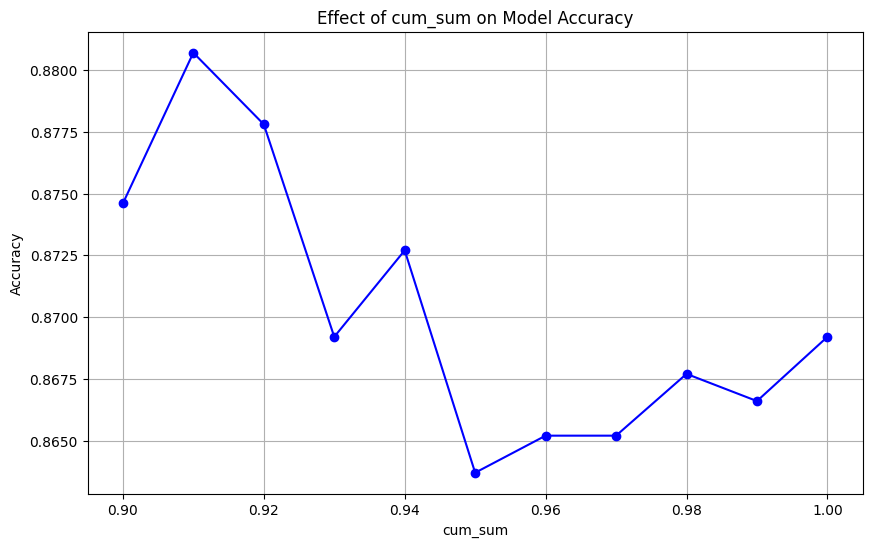

In [176]:
area_cum_sum_df = save_fig(area_cum_sum_params, area_cum_sum_accs, version='area', title='cum_sum')

In [170]:
district_cum_sum_params = [i for i in np.arange(.9, 1.01, 0.01)]
district_cum_sum_accs = [0.8983, 0.9000, 0.9011, 0.9027, 0.9021, 0.8976, 0.8975, 0.8944, 0.8959, 0.8952, 0.8943]

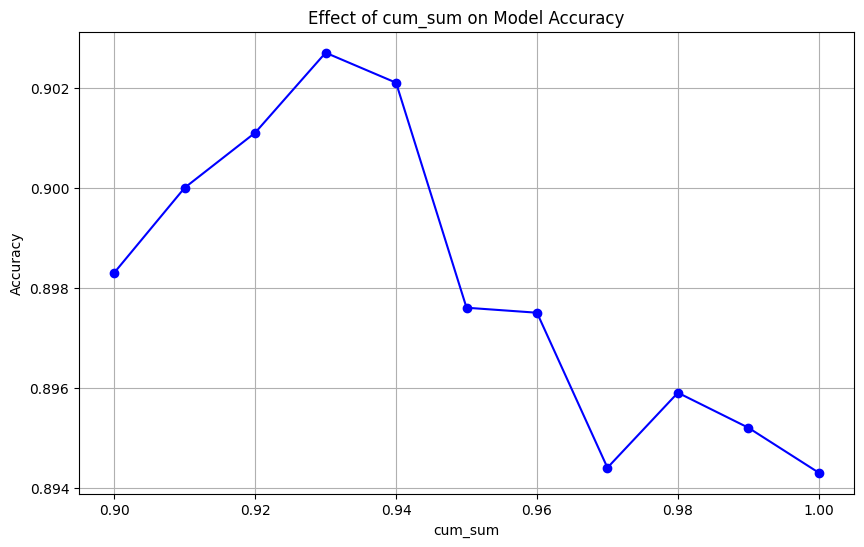

In [172]:
district_cum_sum_df = save_fig(district_cum_sum_params, district_cum_sum_accs, version='district', title='cum_sum')

In [69]:
area_testing_datasets = (rf_area_feature_testing_data[area_top_features], rf_area_target_testing_data)

##### Tuning The Stratified Samples of Selected Features for the Area Model

In [65]:
rf_area_stratified_feature_training_sample_selected = rf_area_stratified_feature_training_sample[area_top_features]
rf_district_stratified_feature_training_sample_selected = rf_district_stratified_feature_training_sample[district_top_features]

In [66]:
area_stratified_selected_training_datasets = (rf_area_stratified_feature_training_sample_selected, rf_area_stratified_target_training_sample)

[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    1.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    6.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 87.2799% found for parameter max_samples at 0.05


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    2.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   14.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 87.9518% found for parameter max_samples at 0.1


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.3108% found for parameter max_samples at 0.15000000000000002


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   27.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.4207% found for parameter max_samples at 0.2


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    6.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   35.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.4553% found for parameter max_samples at 0.25


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    8.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   42.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.0219% found for parameter max_samples at 0.3


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    9.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   47.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.2500% found for parameter max_samples at 0.35000000000000003


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   11.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   54.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 87.9473% found for parameter max_samples at 0.4


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   12.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 87.8120% found for parameter max_samples at 0.45


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   13.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 87.2483% found for parameter max_samples at 0.5


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   14.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.0846% found for parameter max_samples at 0.55


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   16.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.9086% found for parameter max_samples at 0.6000000000000001


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   16.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 87.0008% found for parameter max_samples at 0.6500000000000001


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   17.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.5651% found for parameter max_samples at 0.7000000000000001


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.9634% found for parameter max_samples at 0.7500000000000001


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   18.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.7761% found for parameter max_samples at 0.8


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.5549% found for parameter max_samples at 0.8500000000000001


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.7397% found for parameter max_samples at 0.9000000000000001


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.6280% found for parameter max_samples at 0.9500000000000001


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s


Accuracy of 86.2291% found for parameter max_samples at 1.0


[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished


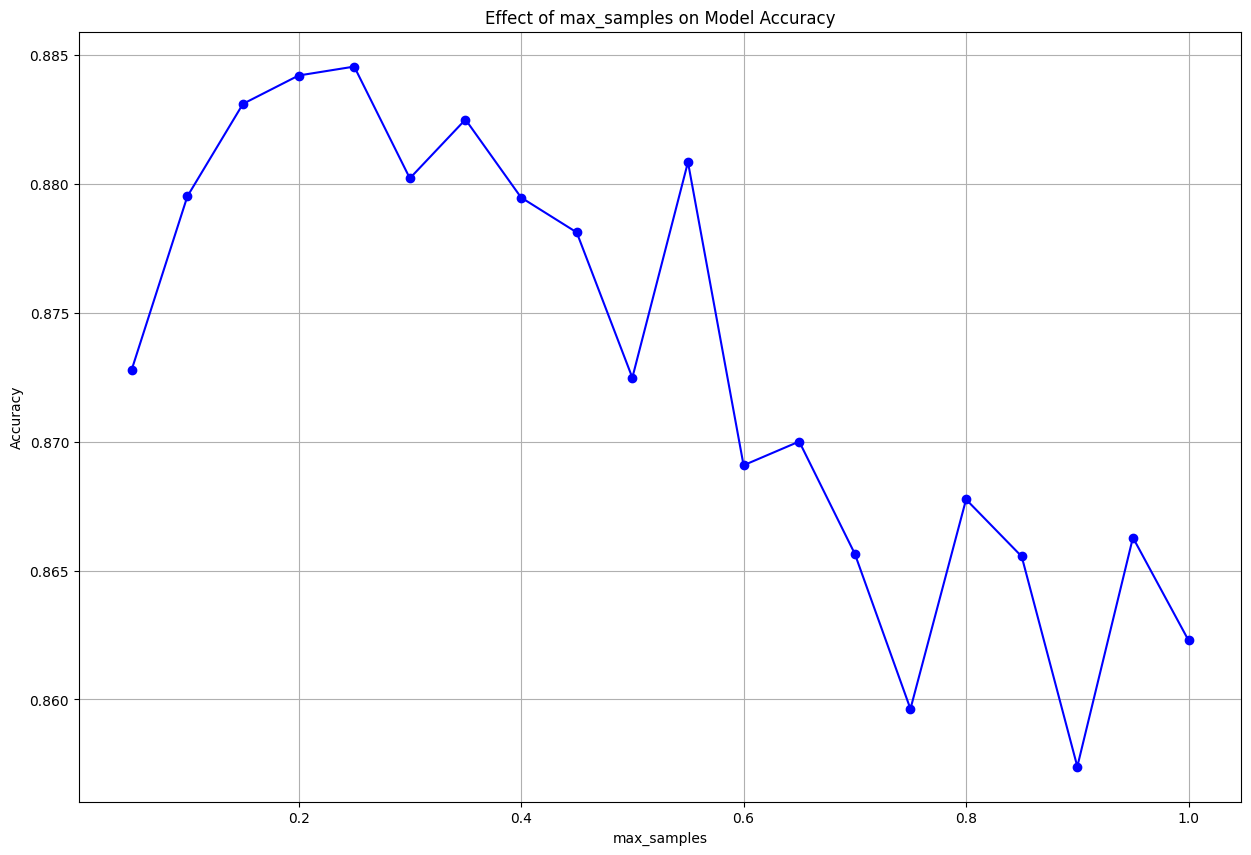

In [75]:
area_stratified_selected_max_sample_params, area_stratified_selected_max_sample_accs = graph_parameter(area_stratified_selected_training_datasets, area_testing_datasets, 'max_samples', 0.05, 1.05, 0.05, min_iteration=1)

[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   23.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.3257% found for parameter min_samples_split at 2


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.3087% found for parameter min_samples_split at 4


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.9272% found for parameter min_samples_split at 6


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   23.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.7025% found for parameter min_samples_split at 8


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.6348% found for parameter min_samples_split at 10


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.1489% found for parameter min_samples_split at 12


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.3567% found for parameter min_samples_split at 14


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.7081% found for parameter min_samples_split at 16


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.6979% found for parameter min_samples_split at 18


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished


Accuracy of 86.9320% found for parameter min_samples_split at 20


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 87.5239% found for parameter min_samples_split at 22


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 87.6560% found for parameter min_samples_split at 24


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished


Accuracy of 86.9765% found for parameter min_samples_split at 26


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 87.3111% found for parameter min_samples_split at 28


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 87.4079% found for parameter min_samples_split at 30


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   23.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 87.5969% found for parameter min_samples_split at 32


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 87.5879% found for parameter min_samples_split at 34


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   23.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished


Accuracy of 87.5279% found for parameter min_samples_split at 36


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished


Accuracy of 87.6908% found for parameter min_samples_split at 38


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished


Accuracy of 86.9935% found for parameter min_samples_split at 40


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 87.0201% found for parameter min_samples_split at 42


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 87.5339% found for parameter min_samples_split at 44


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 87.6343% found for parameter min_samples_split at 46


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   23.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 87.6344% found for parameter min_samples_split at 48


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s


Accuracy of 87.8132% found for parameter min_samples_split at 50


[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished


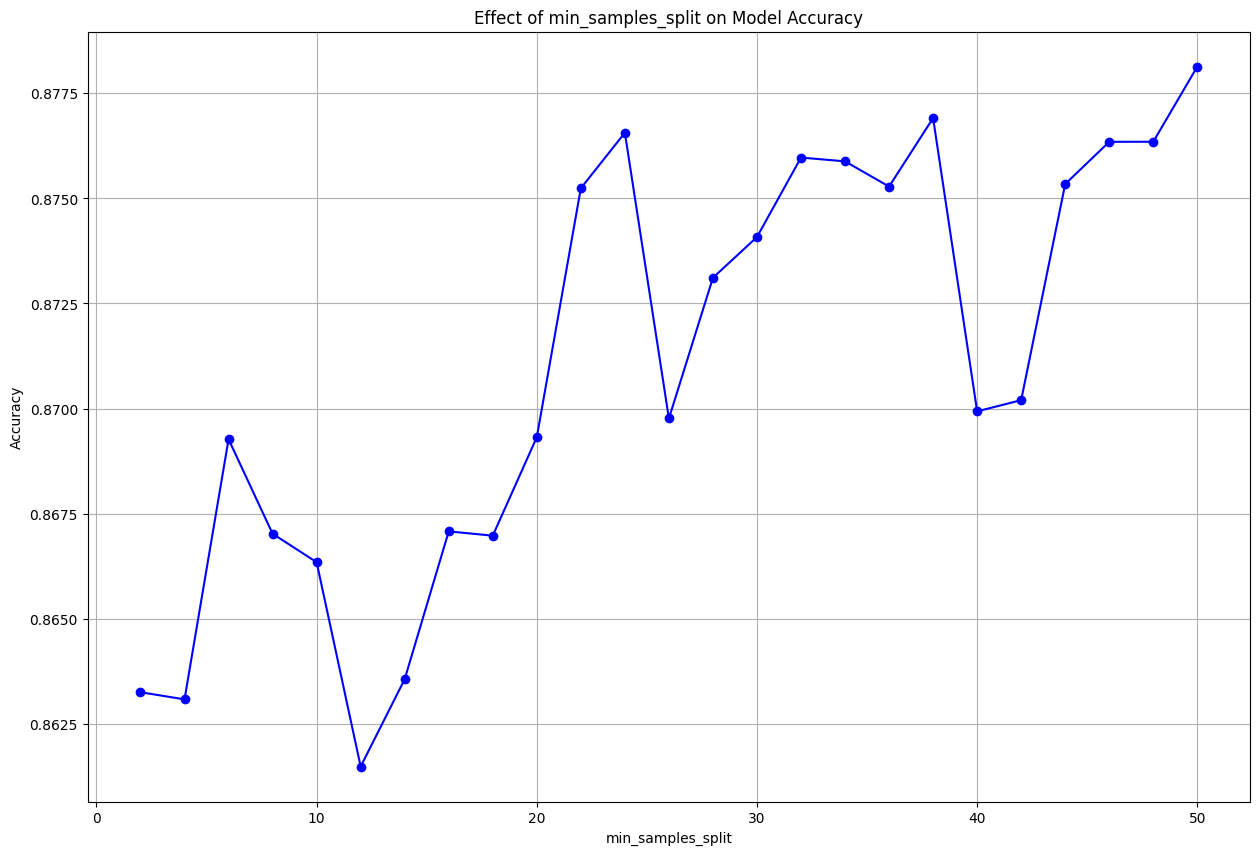

In [76]:
area_stratified_selected_min_samples_split_params, area_stratified_selected_min_samples_split_accs = graph_parameter(area_stratified_selected_training_datasets, area_testing_datasets, 'min_samples_split', 2, -1, 2, min_iteration=20)

[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.1212% found for parameter min_samples_split at 52


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished


Accuracy of 88.2721% found for parameter min_samples_split at 54


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.3650% found for parameter min_samples_split at 56


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   23.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.4809% found for parameter min_samples_split at 58


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.4789% found for parameter min_samples_split at 60


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   23.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.4670% found for parameter min_samples_split at 62


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished


Accuracy of 88.4278% found for parameter min_samples_split at 64


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.4928% found for parameter min_samples_split at 66


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.4889% found for parameter min_samples_split at 68


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.4962% found for parameter min_samples_split at 70


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   23.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.4752% found for parameter min_samples_split at 72


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   23.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.4049% found for parameter min_samples_split at 74


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   23.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.5172% found for parameter min_samples_split at 76


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   23.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.4251% found for parameter min_samples_split at 78


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   23.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.4682% found for parameter min_samples_split at 80


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.5434% found for parameter min_samples_split at 82


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.4632% found for parameter min_samples_split at 84


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.4860% found for parameter min_samples_split at 86


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.4029% found for parameter min_samples_split at 88


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.4171% found for parameter min_samples_split at 90


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   24.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.3766% found for parameter min_samples_split at 92


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.4820% found for parameter min_samples_split at 94


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   23.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.3884% found for parameter min_samples_split at 96


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   23.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.3572% found for parameter min_samples_split at 98


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished


Accuracy of 88.4175% found for parameter min_samples_split at 100


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished


Accuracy of 88.3463% found for parameter min_samples_split at 102


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s


Accuracy of 88.4391% found for parameter min_samples_split at 104


[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished


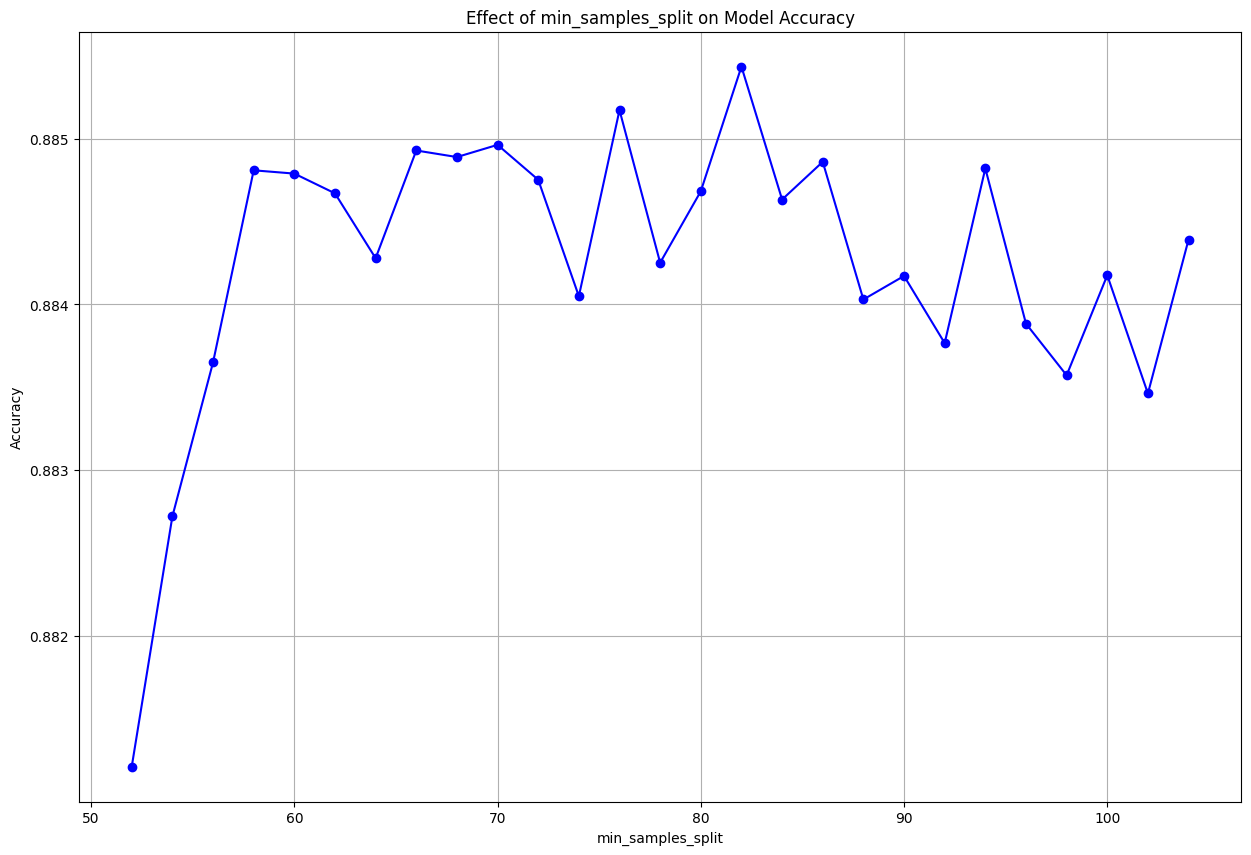

In [80]:
area_stratified_selected_min_samples_split_params_b, area_stratified_selected_min_samples_split_accs_b = graph_parameter(area_stratified_selected_training_datasets, area_testing_datasets, 'min_samples_split', 52, -1, 2, min_iteration=15, max_tolerable_changes=10)

[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    6.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   33.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 18.2595% found for parameter max_leaf_nodes at 2


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   13.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 66.5387% found for parameter max_leaf_nodes at 52


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   13.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 72.4733% found for parameter max_leaf_nodes at 102


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   15.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 75.3784% found for parameter max_leaf_nodes at 152


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   15.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 77.1867% found for parameter max_leaf_nodes at 202


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   16.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 77.8288% found for parameter max_leaf_nodes at 252


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   16.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 78.1427% found for parameter max_leaf_nodes at 302


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   16.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 79.0346% found for parameter max_leaf_nodes at 352


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   17.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 80.3187% found for parameter max_leaf_nodes at 402


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   16.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 80.9713% found for parameter max_leaf_nodes at 452


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   16.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 81.9118% found for parameter max_leaf_nodes at 502


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   16.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.5s finished


Accuracy of 80.9951% found for parameter max_leaf_nodes at 552


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   16.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 81.7860% found for parameter max_leaf_nodes at 602


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   17.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 81.8675% found for parameter max_leaf_nodes at 652


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   16.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished


Accuracy of 82.1271% found for parameter max_leaf_nodes at 702


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   16.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.5s finished


Accuracy of 82.2370% found for parameter max_leaf_nodes at 752


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   16.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 81.8827% found for parameter max_leaf_nodes at 802


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   17.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 82.4580% found for parameter max_leaf_nodes at 852


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   16.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 82.8174% found for parameter max_leaf_nodes at 902


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   16.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 83.1304% found for parameter max_leaf_nodes at 952


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   17.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 83.3583% found for parameter max_leaf_nodes at 1002


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   17.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 83.2157% found for parameter max_leaf_nodes at 1052


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   17.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 83.7593% found for parameter max_leaf_nodes at 1102


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 83.8617% found for parameter max_leaf_nodes at 1152


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   18.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 83.7948% found for parameter max_leaf_nodes at 1202


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.3992% found for parameter max_leaf_nodes at 1252


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 83.0851% found for parameter max_leaf_nodes at 1302


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 82.7763% found for parameter max_leaf_nodes at 1352


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 82.6512% found for parameter max_leaf_nodes at 1402


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 83.6078% found for parameter max_leaf_nodes at 1452


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   18.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.5s finished


Accuracy of 83.9713% found for parameter max_leaf_nodes at 1502


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 83.9331% found for parameter max_leaf_nodes at 1552


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.3766% found for parameter max_leaf_nodes at 1602


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   18.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.5s finished


Accuracy of 83.8558% found for parameter max_leaf_nodes at 1652


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.5514% found for parameter max_leaf_nodes at 1702


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.0641% found for parameter max_leaf_nodes at 1752


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.1856% found for parameter max_leaf_nodes at 1802


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.1421% found for parameter max_leaf_nodes at 1852


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 83.2383% found for parameter max_leaf_nodes at 1902


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.6817% found for parameter max_leaf_nodes at 1952


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.1033% found for parameter max_leaf_nodes at 2002


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.7443% found for parameter max_leaf_nodes at 2052


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.3127% found for parameter max_leaf_nodes at 2102


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.4619% found for parameter max_leaf_nodes at 2152


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.5286% found for parameter max_leaf_nodes at 2202


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.4889% found for parameter max_leaf_nodes at 2252


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.2633% found for parameter max_leaf_nodes at 2302


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.1210% found for parameter max_leaf_nodes at 2352


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished


Accuracy of 84.4826% found for parameter max_leaf_nodes at 2402


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished


Accuracy of 85.0870% found for parameter max_leaf_nodes at 2452


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.1324% found for parameter max_leaf_nodes at 2502


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.9262% found for parameter max_leaf_nodes at 2552


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.8040% found for parameter max_leaf_nodes at 2602


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.0228% found for parameter max_leaf_nodes at 2652


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.2614% found for parameter max_leaf_nodes at 2702


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished


Accuracy of 84.6106% found for parameter max_leaf_nodes at 2752


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.7558% found for parameter max_leaf_nodes at 2802


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.3787% found for parameter max_leaf_nodes at 2852


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.9103% found for parameter max_leaf_nodes at 2902


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.3950% found for parameter max_leaf_nodes at 2952


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.5s finished


Accuracy of 85.2097% found for parameter max_leaf_nodes at 3002


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.2156% found for parameter max_leaf_nodes at 3052


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.7959% found for parameter max_leaf_nodes at 3102


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.7110% found for parameter max_leaf_nodes at 3152


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished


Accuracy of 84.7797% found for parameter max_leaf_nodes at 3202


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.5756% found for parameter max_leaf_nodes at 3252


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.6889% found for parameter max_leaf_nodes at 3302


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.5676% found for parameter max_leaf_nodes at 3352


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.1924% found for parameter max_leaf_nodes at 3402


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.5205% found for parameter max_leaf_nodes at 3452


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.1850% found for parameter max_leaf_nodes at 3502


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.6090% found for parameter max_leaf_nodes at 3552


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.6935% found for parameter max_leaf_nodes at 3602


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.7232% found for parameter max_leaf_nodes at 3652


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.4107% found for parameter max_leaf_nodes at 3702


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished


Accuracy of 85.2067% found for parameter max_leaf_nodes at 3752


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.7196% found for parameter max_leaf_nodes at 3802


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.6954% found for parameter max_leaf_nodes at 3852


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.7921% found for parameter max_leaf_nodes at 3902


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.7785% found for parameter max_leaf_nodes at 3952


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.9789% found for parameter max_leaf_nodes at 4002


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.3658% found for parameter max_leaf_nodes at 4052


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.4311% found for parameter max_leaf_nodes at 4102


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.4009% found for parameter max_leaf_nodes at 4152


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.5393% found for parameter max_leaf_nodes at 4202


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.6099% found for parameter max_leaf_nodes at 4252


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.9771% found for parameter max_leaf_nodes at 4302


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.1748% found for parameter max_leaf_nodes at 4352


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.9345% found for parameter max_leaf_nodes at 4402


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.6649% found for parameter max_leaf_nodes at 4452


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.1371% found for parameter max_leaf_nodes at 4502


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.0624% found for parameter max_leaf_nodes at 4552


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished


Accuracy of 86.5948% found for parameter max_leaf_nodes at 4602


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.8384% found for parameter max_leaf_nodes at 4652


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.9446% found for parameter max_leaf_nodes at 4702


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished


Accuracy of 85.6818% found for parameter max_leaf_nodes at 4752


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.9088% found for parameter max_leaf_nodes at 4802


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.3921% found for parameter max_leaf_nodes at 4852


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished


Accuracy of 85.2943% found for parameter max_leaf_nodes at 4902


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.7927% found for parameter max_leaf_nodes at 4952


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.8948% found for parameter max_leaf_nodes at 5002


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.3936% found for parameter max_leaf_nodes at 5052


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished


Accuracy of 85.9795% found for parameter max_leaf_nodes at 5102


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.5580% found for parameter max_leaf_nodes at 5152


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished


Accuracy of 85.2910% found for parameter max_leaf_nodes at 5202


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.9618% found for parameter max_leaf_nodes at 5252


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.1573% found for parameter max_leaf_nodes at 5302


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.3497% found for parameter max_leaf_nodes at 5352


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.7907% found for parameter max_leaf_nodes at 5402


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.8024% found for parameter max_leaf_nodes at 5452


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.1283% found for parameter max_leaf_nodes at 5502


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.0367% found for parameter max_leaf_nodes at 5552


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   23.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.8659% found for parameter max_leaf_nodes at 5602


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.1664% found for parameter max_leaf_nodes at 5652


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished


Accuracy of 85.5744% found for parameter max_leaf_nodes at 5702


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s


Accuracy of 86.0839% found for parameter max_leaf_nodes at 5752


[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished


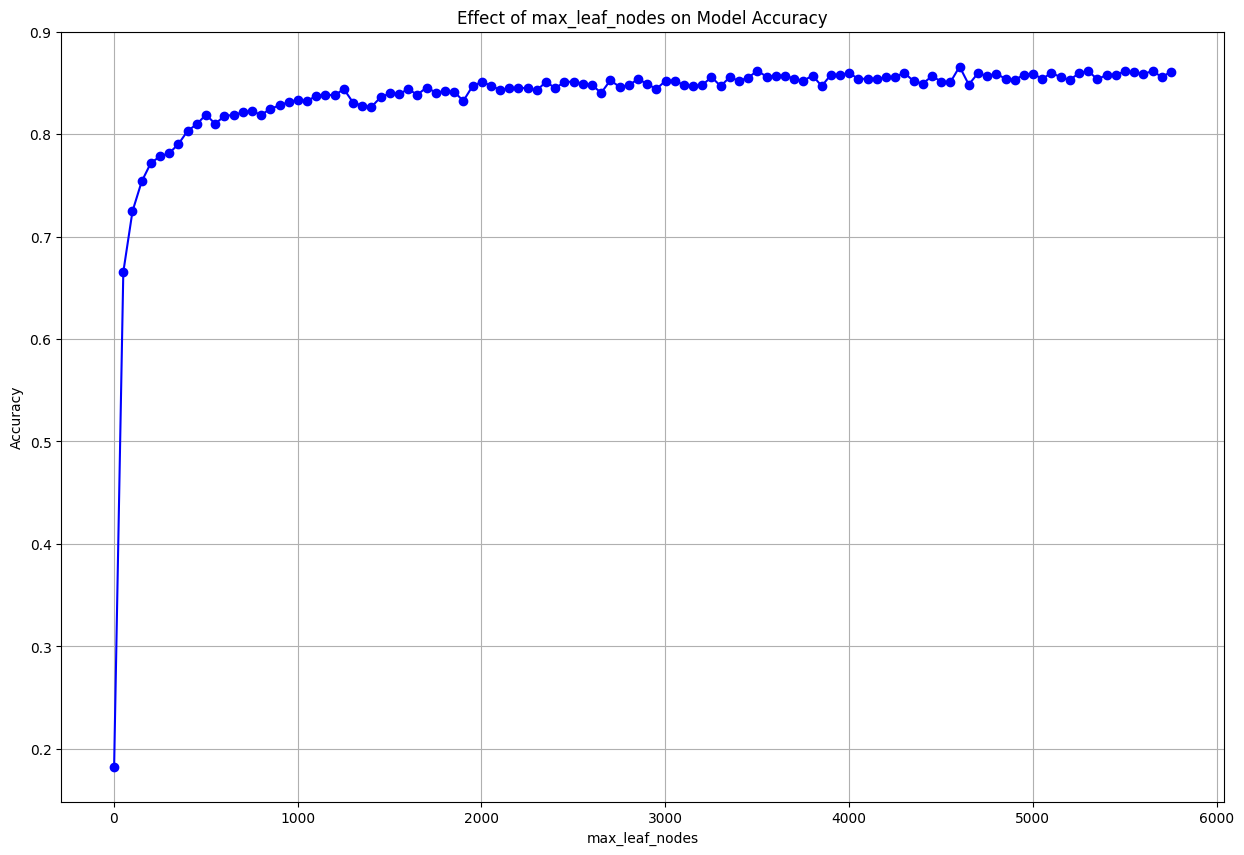

In [81]:
area_stratified_selected_max_leaf_nodes_params, area_stratified_selected_max_leaf_nodes_accs = graph_parameter(area_stratified_selected_training_datasets, area_testing_datasets, 'max_leaf_nodes', 2, -1, 50, min_iteration=10, tolerance=0.01, max_tolerable_changes=20)

[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 87.0370% found for parameter min_samples_leaf at 2


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 87.0234% found for parameter min_samples_leaf at 22


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.7629% found for parameter min_samples_leaf at 42


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished


Accuracy of 85.1180% found for parameter min_samples_leaf at 62


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.4330% found for parameter min_samples_leaf at 82


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.0318% found for parameter min_samples_leaf at 102


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished


Accuracy of 83.6310% found for parameter min_samples_leaf at 122


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 83.2398% found for parameter min_samples_leaf at 142


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 82.6523% found for parameter min_samples_leaf at 162


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 82.1654% found for parameter min_samples_leaf at 182


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 81.8206% found for parameter min_samples_leaf at 202


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 81.5489% found for parameter min_samples_leaf at 222


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   18.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 81.1407% found for parameter min_samples_leaf at 242


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 80.8451% found for parameter min_samples_leaf at 262


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   18.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 80.7252% found for parameter min_samples_leaf at 282


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 80.3938% found for parameter min_samples_leaf at 302


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 80.1704% found for parameter min_samples_leaf at 322


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 79.9606% found for parameter min_samples_leaf at 342


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished


Accuracy of 79.7555% found for parameter min_samples_leaf at 362


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   18.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 79.7317% found for parameter min_samples_leaf at 382


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 79.4639% found for parameter min_samples_leaf at 402


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   18.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 79.3877% found for parameter min_samples_leaf at 422


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   18.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 78.9366% found for parameter min_samples_leaf at 442


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished


Accuracy of 78.5826% found for parameter min_samples_leaf at 462


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   18.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 78.5401% found for parameter min_samples_leaf at 482


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 78.3210% found for parameter min_samples_leaf at 502


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   17.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 78.0154% found for parameter min_samples_leaf at 522


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   18.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 77.8228% found for parameter min_samples_leaf at 542


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   17.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 77.6958% found for parameter min_samples_leaf at 562


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 77.5650% found for parameter min_samples_leaf at 582


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   18.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 77.3344% found for parameter min_samples_leaf at 602


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   18.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 77.1648% found for parameter min_samples_leaf at 622


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   17.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 77.0000% found for parameter min_samples_leaf at 642


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   18.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 76.8321% found for parameter min_samples_leaf at 662


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   18.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 76.7691% found for parameter min_samples_leaf at 682


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   18.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 76.6569% found for parameter min_samples_leaf at 702


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 76.6633% found for parameter min_samples_leaf at 722


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 76.5920% found for parameter min_samples_leaf at 742


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 76.2772% found for parameter min_samples_leaf at 762


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 76.1766% found for parameter min_samples_leaf at 782


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 76.1394% found for parameter min_samples_leaf at 802


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished


Accuracy of 75.9056% found for parameter min_samples_leaf at 822


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   18.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 75.9000% found for parameter min_samples_leaf at 842


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 75.7530% found for parameter min_samples_leaf at 862


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 75.6244% found for parameter min_samples_leaf at 882


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 75.5563% found for parameter min_samples_leaf at 902


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished


Accuracy of 75.1343% found for parameter min_samples_leaf at 922


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 75.1137% found for parameter min_samples_leaf at 942


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 74.8749% found for parameter min_samples_leaf at 962


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 74.8792% found for parameter min_samples_leaf at 982


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   18.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 74.6701% found for parameter min_samples_leaf at 1002


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 74.5832% found for parameter min_samples_leaf at 1022


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 74.3960% found for parameter min_samples_leaf at 1042


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 74.1450% found for parameter min_samples_leaf at 1062


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 73.7799% found for parameter min_samples_leaf at 1082


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 74.0091% found for parameter min_samples_leaf at 1102


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 73.6714% found for parameter min_samples_leaf at 1122


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 73.3702% found for parameter min_samples_leaf at 1142


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 73.4148% found for parameter min_samples_leaf at 1162


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 73.3292% found for parameter min_samples_leaf at 1182


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   18.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 73.0598% found for parameter min_samples_leaf at 1202


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 73.1208% found for parameter min_samples_leaf at 1222


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished


Accuracy of 73.0988% found for parameter min_samples_leaf at 1242


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 72.8958% found for parameter min_samples_leaf at 1262


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 72.8506% found for parameter min_samples_leaf at 1282


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 72.7525% found for parameter min_samples_leaf at 1302


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   18.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s


Accuracy of 72.7764% found for parameter min_samples_leaf at 1322


[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished


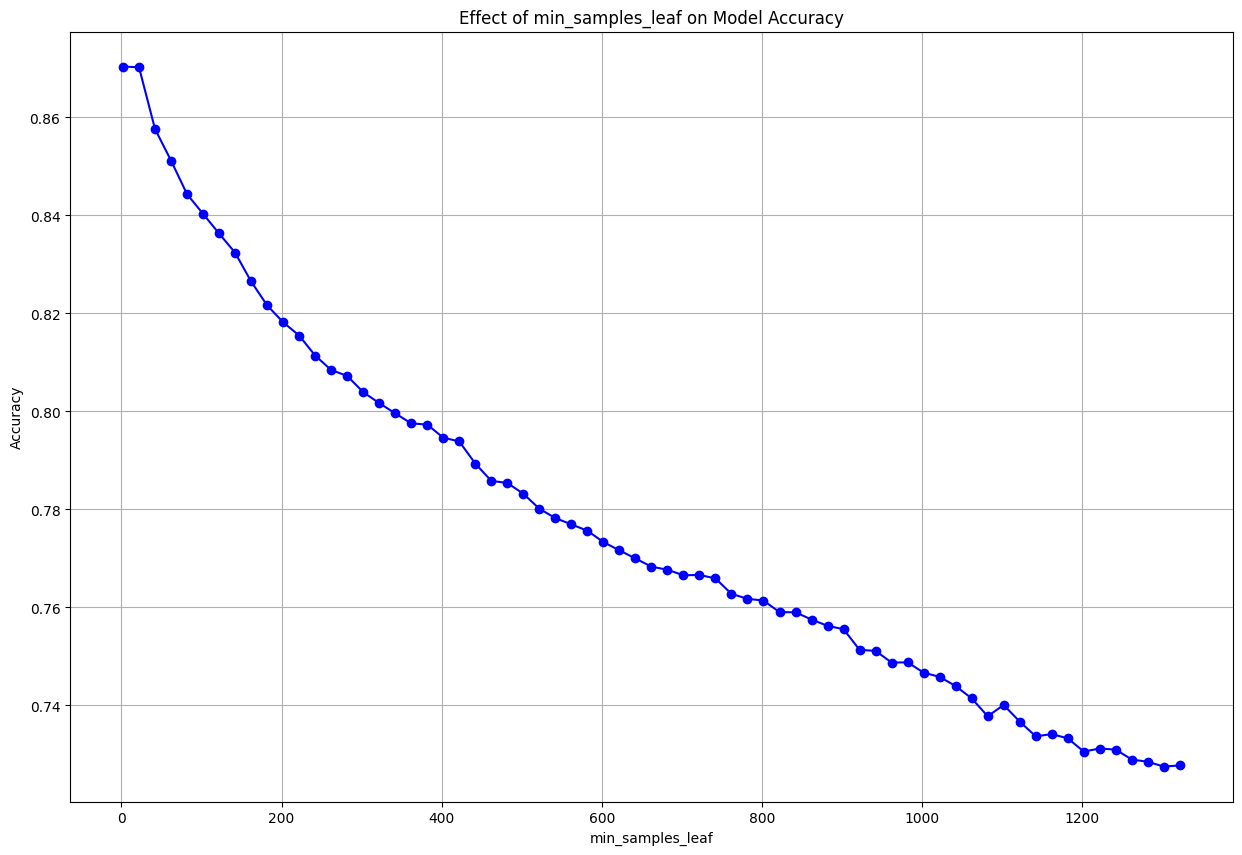

In [82]:
area_stratified_selected_min_samples_leaf_params, area_stratified_selected_min_samples_leaf_accs = graph_parameter(area_stratified_selected_training_datasets, area_testing_datasets, 'min_samples_leaf', 2, -1, 20, min_iteration=40, tolerance=0.01, max_tolerable_changes=25)

In [ ]:
area_stratified_selected_n_estimators_params, area_stratified_selected_n_estimators_accs = graph_parameter(area_stratified_selected_training_datasets, area_testing_datasets, 'n_estimators', 25, -1, 25, min_iteration=40, tolerance=0.01, max_tolerable_changes=25)

In [85]:
area_stratified_selected_n_estimators_params = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975]
area_stratified_selected_n_estimators_accs = [87.2639, 86.0286, 85.7569, 86.5940, 86.0527, 86.3876, 86.2875, 85.9165, 86.4183, 86.6067, 86.0001, 86.3879, 86.2658, 86.3988, 86.1885, 86.3916, 86.4630, 86.0572, 86.1969, 86.3327, 86.1309, 86.2593, 86.4638, 86.2985, 86.1223, 86.3466, 86.3468, 86.2070, 86.3917, 86.2567, 86.3635, 85.9628, 86.4834, 86.6256, 86.3395, 86.2740, 86.1529, 86.3364, 86.4614]

[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    2.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   14.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 81.8908% found for parameter max_features at 1


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   17.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.3831% found for parameter max_features at 2


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   20.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.1220% found for parameter max_features at 3


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   23.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 87.3003% found for parameter max_features at 4


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   27.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 87.7157% found for parameter max_features at 5


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    6.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   29.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.5086% found for parameter max_features at 6


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    6.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   33.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.8971% found for parameter max_features at 7


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    7.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   36.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.2183% found for parameter max_features at 8


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    9.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   39.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.1447% found for parameter max_features at 9


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    9.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   44.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.5158% found for parameter max_features at 10


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   10.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   47.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.6803% found for parameter max_features at 11


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   10.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   51.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.7249% found for parameter max_features at 12


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   12.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   53.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.9629% found for parameter max_features at 13


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   11.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   55.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.9655% found for parameter max_features at 14


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   13.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   59.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.7763% found for parameter max_features at 15


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   14.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 90.0007% found for parameter max_features at 16


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   14.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.8335% found for parameter max_features at 17


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   15.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.4095% found for parameter max_features at 18


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   15.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.6858% found for parameter max_features at 19


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   17.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.3368% found for parameter max_features at 20


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   16.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.6367% found for parameter max_features at 21


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   17.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s


Accuracy of 89.3257% found for parameter max_features at 22


[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished


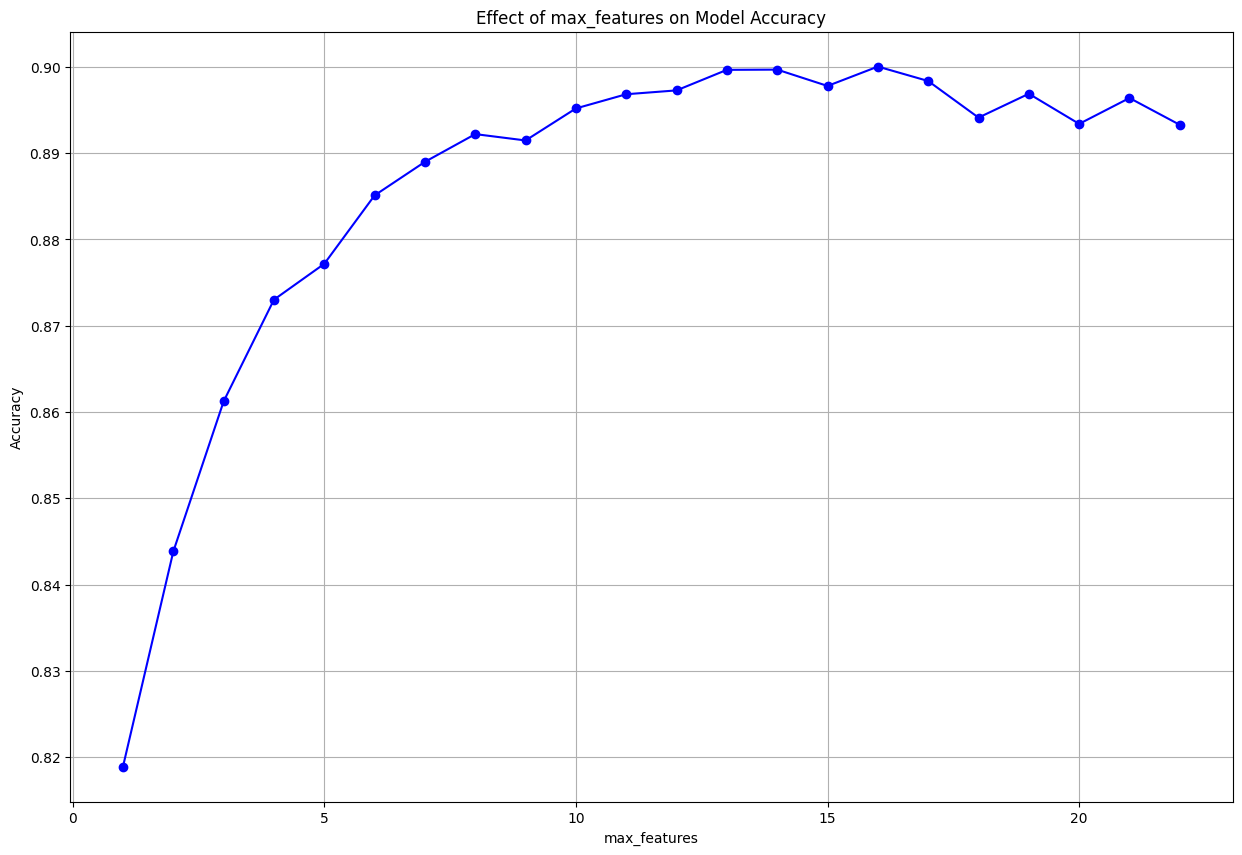

In [87]:
area_stratified_selected_max_features_params, area_stratified_selected_max_features_accs = graph_parameter(area_stratified_selected_training_datasets, area_testing_datasets, 'max_features', 1, -1, 1, min_iteration=15, tolerance=0.01, max_tolerable_changes=5)

[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   17.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 18.2600% found for parameter max_depth at 1


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    6.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   31.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 23.1833% found for parameter max_depth at 2


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    8.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   44.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 30.2347% found for parameter max_depth at 3


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   11.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   55.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 42.7698% found for parameter max_depth at 4


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   13.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 53.2017% found for parameter max_depth at 5


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   15.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 59.0572% found for parameter max_depth at 6


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   16.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 66.7051% found for parameter max_depth at 7


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   17.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 71.9904% found for parameter max_depth at 8


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   18.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished


Accuracy of 77.3363% found for parameter max_depth at 9


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 80.0886% found for parameter max_depth at 10


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   19.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 81.5210% found for parameter max_depth at 11


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 81.2128% found for parameter max_depth at 12


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 83.0802% found for parameter max_depth at 13


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished


Accuracy of 84.7866% found for parameter max_depth at 14


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.3987% found for parameter max_depth at 15


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.6582% found for parameter max_depth at 16


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.2575% found for parameter max_depth at 17


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.6625% found for parameter max_depth at 18


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.7279% found for parameter max_depth at 19


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s


Accuracy of 86.2108% found for parameter max_depth at 20


[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished


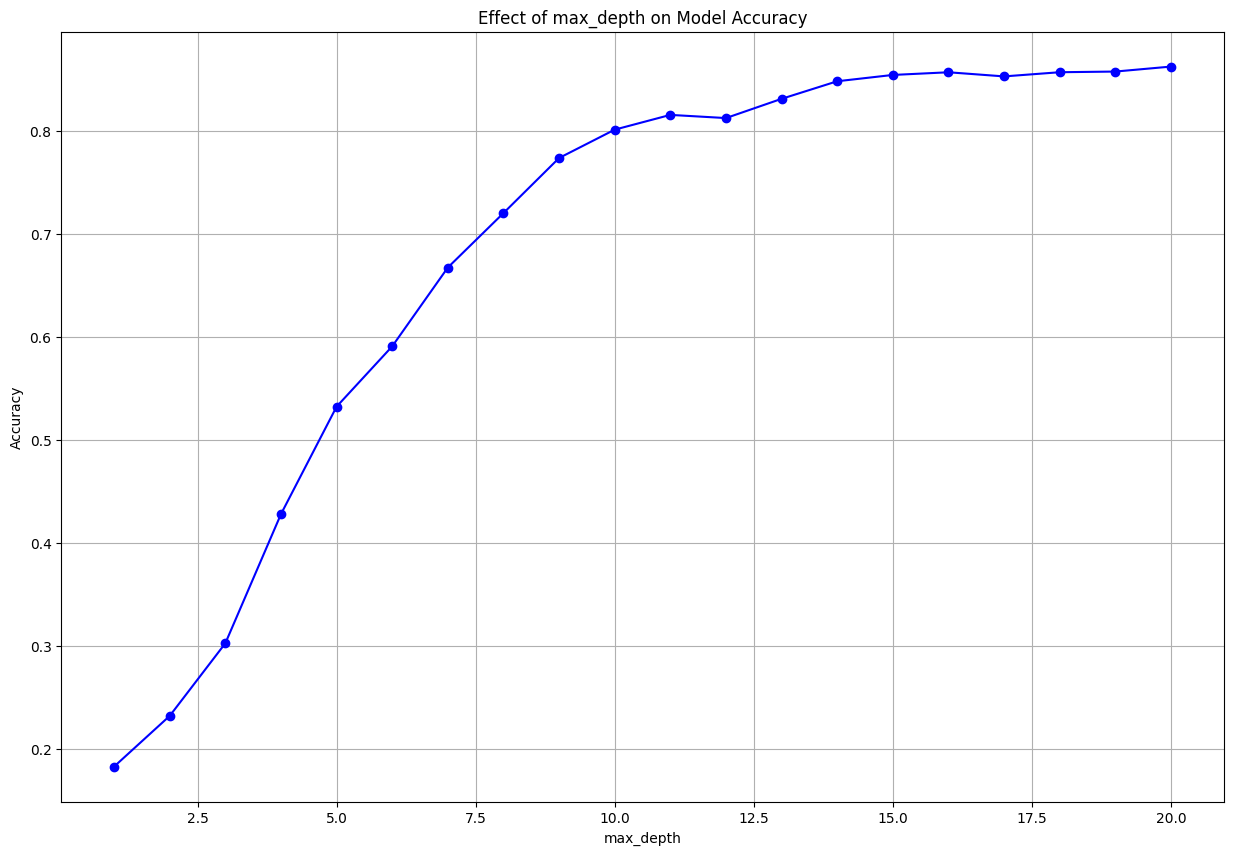

In [89]:
area_stratified_selected_max_depth_params, area_stratified_selected_max_depth_accs = graph_parameter(area_stratified_selected_training_datasets, area_testing_datasets, 'max_depth', 1, -1, 1, min_iteration=15, tolerance=0.01, max_tolerable_changes=3)

[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   20.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.2353% found for parameter max_depth at 21


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.1693% found for parameter max_depth at 22


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.7304% found for parameter max_depth at 23


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.8361% found for parameter max_depth at 24


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.1169% found for parameter max_depth at 25


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.4475% found for parameter max_depth at 26


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.4692% found for parameter max_depth at 27


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   23.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.2450% found for parameter max_depth at 28


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.0639% found for parameter max_depth at 29


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.4651% found for parameter max_depth at 30


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.5825% found for parameter max_depth at 31


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.1163% found for parameter max_depth at 32


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.6317% found for parameter max_depth at 33


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   22.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.8109% found for parameter max_depth at 34


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   21.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.1s


Accuracy of 86.3406% found for parameter max_depth at 35


[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.9s finished


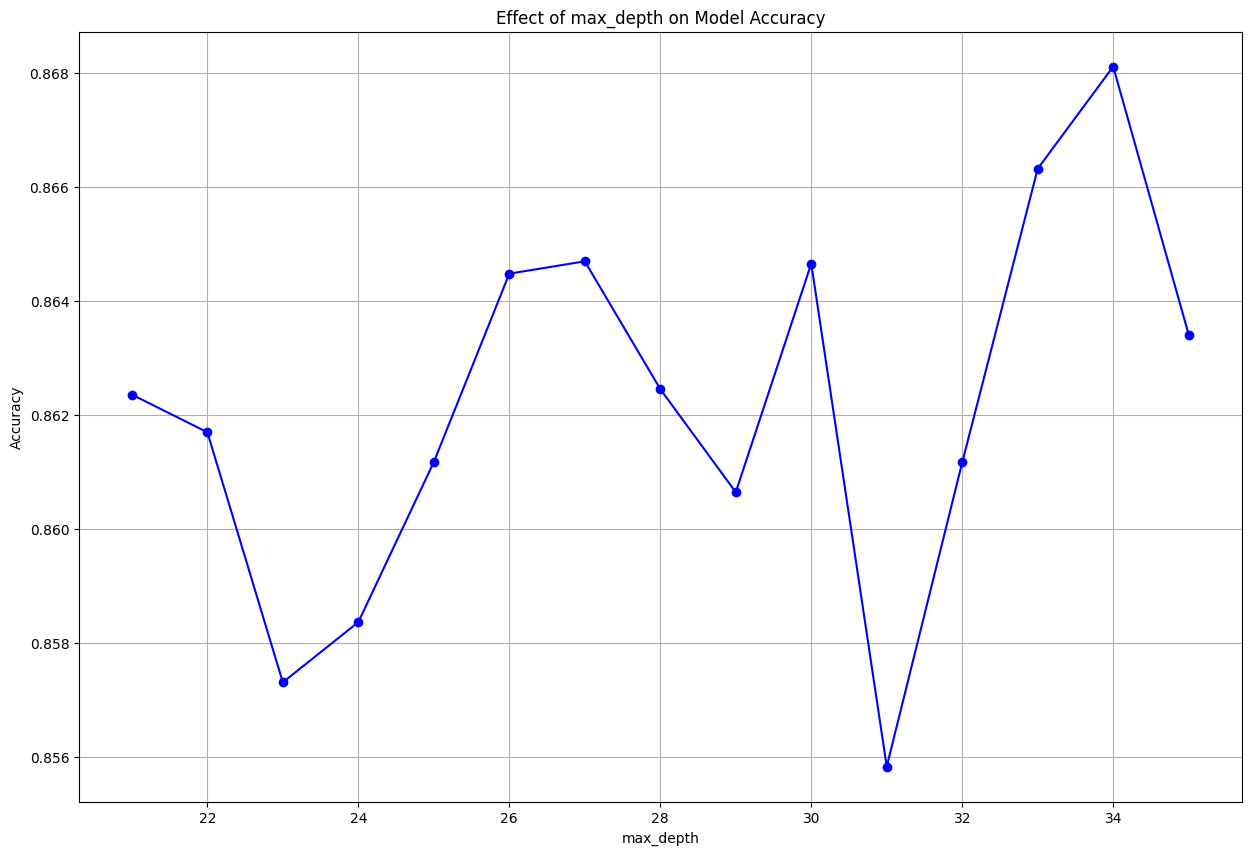

In [91]:
area_stratified_selected_max_depth_params_b, area_stratified_selected_max_depth_accs_b = graph_parameter(area_stratified_selected_training_datasets, area_testing_datasets, 'max_depth', 21, -1, 1, min_iteration=10)

In [94]:
area_stratified_selected_min_samples_split_params, area_stratified_selected_min_samples_split_accs = area_stratified_selected_min_samples_split_params + area_stratified_selected_min_samples_split_params_b, area_stratified_selected_min_samples_split_accs + area_stratified_selected_min_samples_split_accs_b

In [95]:
area_stratified_selected_max_depth_params, area_stratified_selected_max_depth_accs = area_stratified_selected_max_depth_params + area_stratified_selected_max_depth_params_b, area_stratified_selected_max_depth_accs + area_stratified_selected_max_depth_accs_b

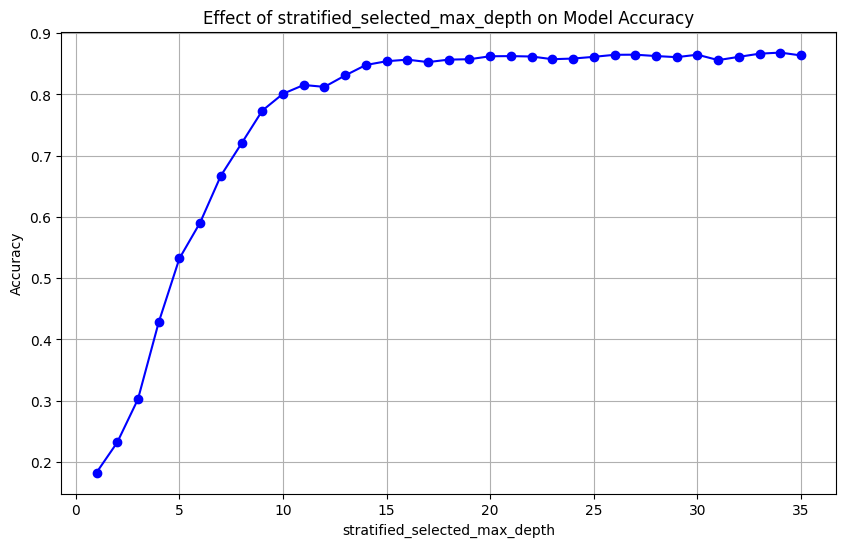

In [97]:
area_stratified_selected_max_depth_df = save_fig(area_stratified_selected_max_depth_params, area_stratified_selected_max_depth_accs, title='stratified_selected_max_depth', version='area')

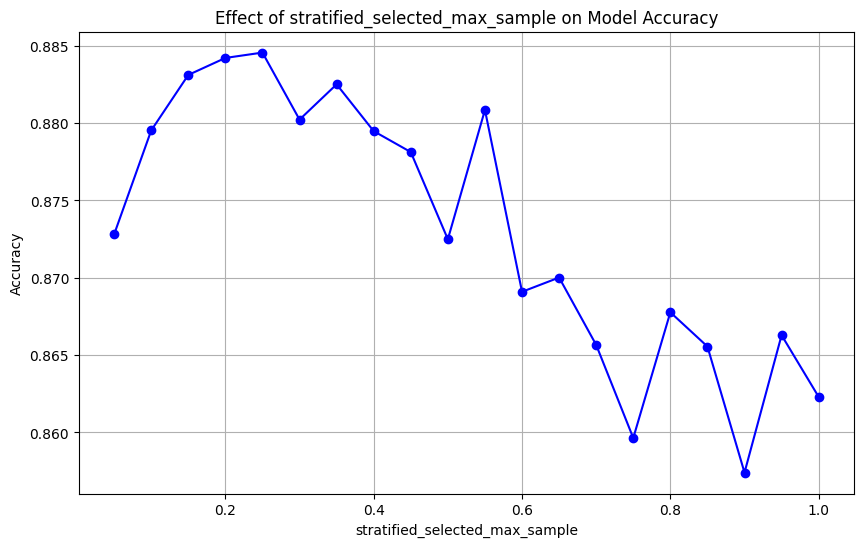

In [98]:
area_stratified_selected_max_sample_df = save_fig(area_stratified_selected_max_sample_params, area_stratified_selected_max_sample_accs, title='stratified_selected_max_sample', version='area')

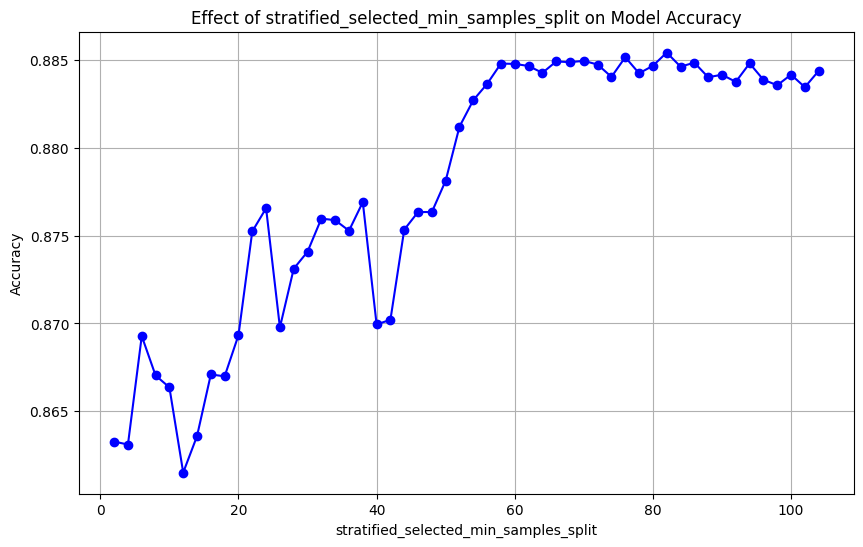

In [99]:
area_stratified_selected_min_samples_split_df = save_fig(area_stratified_selected_min_samples_split_params, area_stratified_selected_min_samples_split_accs, title='stratified_selected_min_samples_split', version='area')

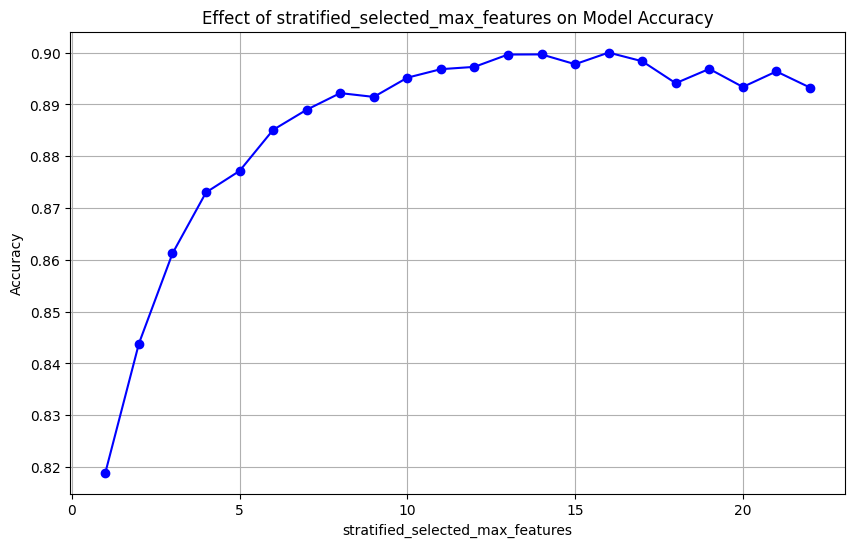

In [100]:
area_stratified_selected_max_features_df = save_fig(area_stratified_selected_max_features_params, area_stratified_selected_max_features_accs, title='stratified_selected_max_features', version='area')

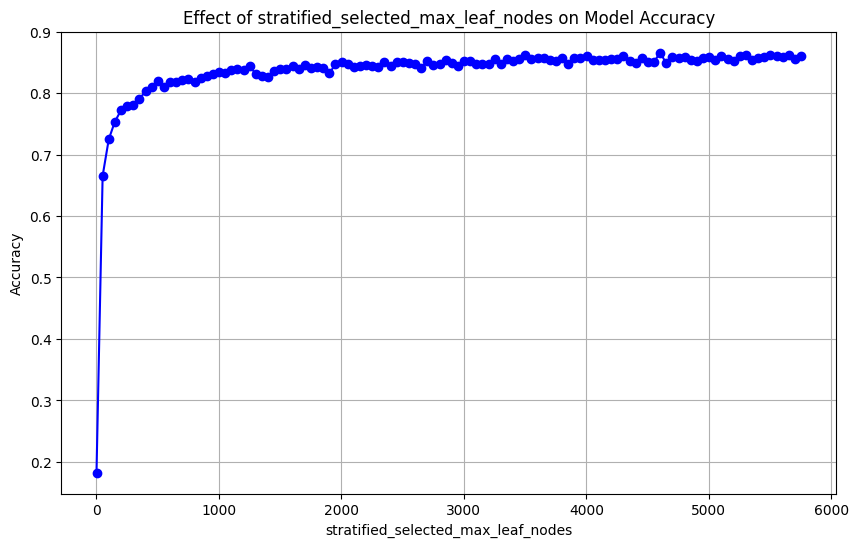

In [101]:
area_stratified_selected_max_leaf_nodes_df = save_fig(area_stratified_selected_max_leaf_nodes_params, area_stratified_selected_max_leaf_nodes_accs, title='stratified_selected_max_leaf_nodes', version='area')

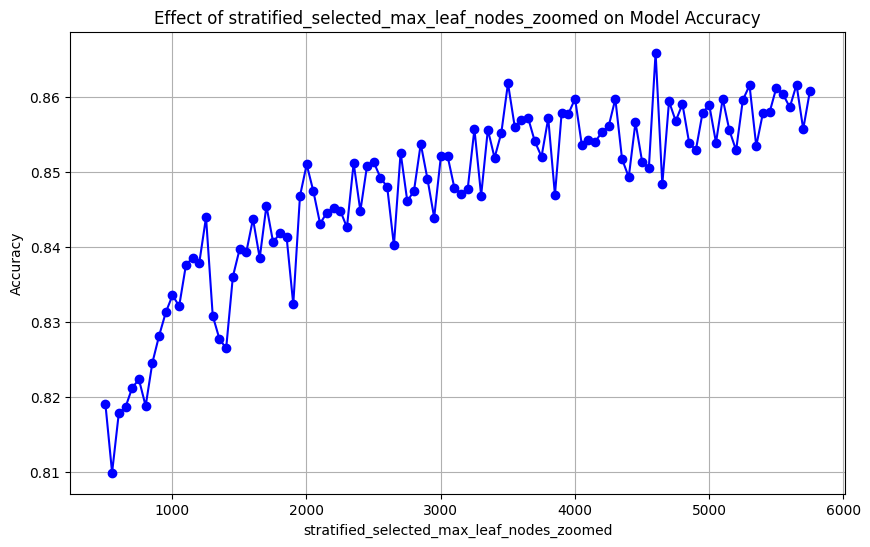

In [143]:
_ = save_fig(area_stratified_selected_max_leaf_nodes_df[area_stratified_selected_max_leaf_nodes_df['params'] >= 500]['params'].values, area_stratified_selected_max_leaf_nodes_df[area_stratified_selected_max_leaf_nodes_df['params'] >= 500]['accs'].values, title='stratified_selected_max_leaf_nodes_zoomed', version='area')

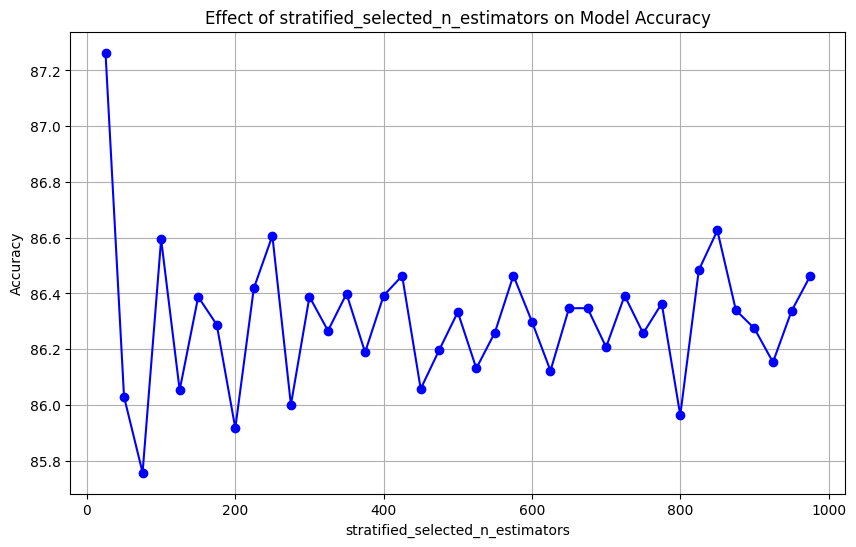

In [102]:
area_stratified_selected_n_estimators_df = save_fig(area_stratified_selected_n_estimators_params, area_stratified_selected_n_estimators_accs, title='stratified_selected_n_estimators', version='area')

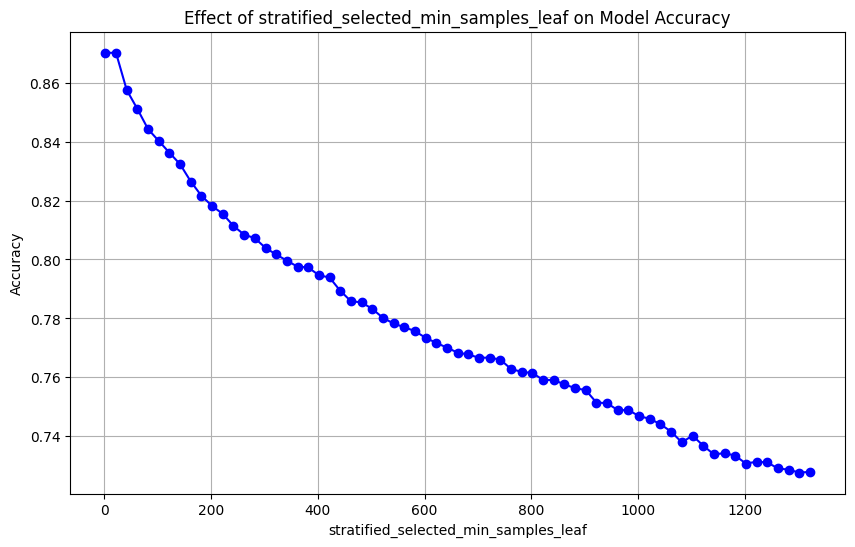

In [103]:
area_stratified_selected_min_samples_leaf_df = save_fig(area_stratified_selected_min_samples_leaf_params, area_stratified_selected_min_samples_leaf_accs, title='stratified_selected_min_samples_leaf', version='area')

##### Tuning The Samples of Selected Features for the District Model

In [104]:
district_training_datasets = (rf_district_feature_training_data[district_top_features], rf_district_target_training_data)
district_testing_datasets = (rf_district_feature_testing_data[district_top_features], rf_district_target_testing_data)

[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.8807% found for parameter max_samples at 0.05


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.0897% found for parameter max_samples at 0.1


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    4.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.8908% found for parameter max_samples at 0.15000000000000002


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    1.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    6.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 88.9977% found for parameter max_samples at 0.2


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    1.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    8.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.4314% found for parameter max_samples at 0.25


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    1.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    9.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.5544% found for parameter max_samples at 0.3


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    2.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   11.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.5548% found for parameter max_samples at 0.35000000000000003


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    2.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   12.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.7418% found for parameter max_samples at 0.4


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    2.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   13.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.9784% found for parameter max_samples at 0.45


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    2.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   14.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.9144% found for parameter max_samples at 0.5


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   16.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.1748% found for parameter max_samples at 0.55


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   17.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.0672% found for parameter max_samples at 0.6000000000000001


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   17.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.1523% found for parameter max_samples at 0.6500000000000001


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   19.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.0270% found for parameter max_samples at 0.7000000000000001


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   18.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.0980% found for parameter max_samples at 0.7500000000000001


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.0636% found for parameter max_samples at 0.8


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   22.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.3210% found for parameter max_samples at 0.8500000000000001


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   22.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.8968% found for parameter max_samples at 0.9000000000000001


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   24.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.9600% found for parameter max_samples at 0.9500000000000001


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   24.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.1133% found for parameter max_samples at 1.0


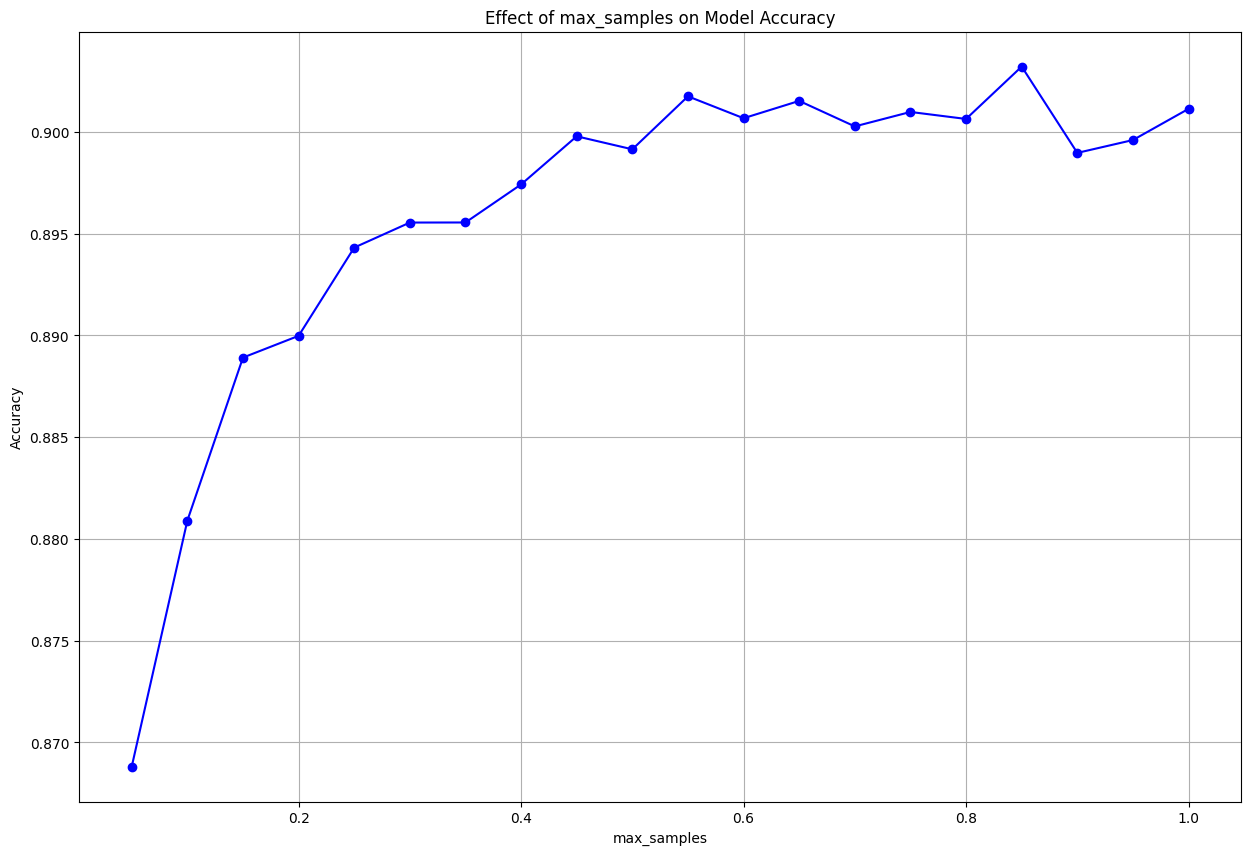

In [105]:
district_max_sample_params, district_max_sample_accs = graph_parameter(district_training_datasets, district_testing_datasets, 'max_samples', 0.05, 1.05, 0.05, min_iteration=1)

[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 18.5406% found for parameter max_depth at 1


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    1.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    4.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 26.3694% found for parameter max_depth at 2


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    1.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    6.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 39.6038% found for parameter max_depth at 3


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    1.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    8.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 46.8680% found for parameter max_depth at 4


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    2.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    9.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 57.4028% found for parameter max_depth at 5


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    2.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   11.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 62.9196% found for parameter max_depth at 6


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    2.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   12.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 68.2439% found for parameter max_depth at 7


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    2.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   13.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 75.1203% found for parameter max_depth at 8


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   15.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 78.5832% found for parameter max_depth at 9


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   15.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 82.0094% found for parameter max_depth at 10


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   14.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.4580% found for parameter max_depth at 11


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   17.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.3622% found for parameter max_depth at 12


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   18.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 87.6108% found for parameter max_depth at 13


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   19.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.3681% found for parameter max_depth at 14


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   20.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.0657% found for parameter max_depth at 15


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   20.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.2171% found for parameter max_depth at 16


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   22.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.3301% found for parameter max_depth at 17


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   22.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.9070% found for parameter max_depth at 18


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.8166% found for parameter max_depth at 19


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   23.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.0919% found for parameter max_depth at 20


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   23.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.0404% found for parameter max_depth at 21


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   22.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.1544% found for parameter max_depth at 22


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.1704% found for parameter max_depth at 23


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   25.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.2497% found for parameter max_depth at 24


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   24.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.0870% found for parameter max_depth at 25


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   24.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.2747% found for parameter max_depth at 26


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   25.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.3575% found for parameter max_depth at 27


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   25.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.3470% found for parameter max_depth at 28


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   25.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.2094% found for parameter max_depth at 29


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   25.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.9850% found for parameter max_depth at 30


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   24.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.2402% found for parameter max_depth at 31


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   24.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.0999% found for parameter max_depth at 32


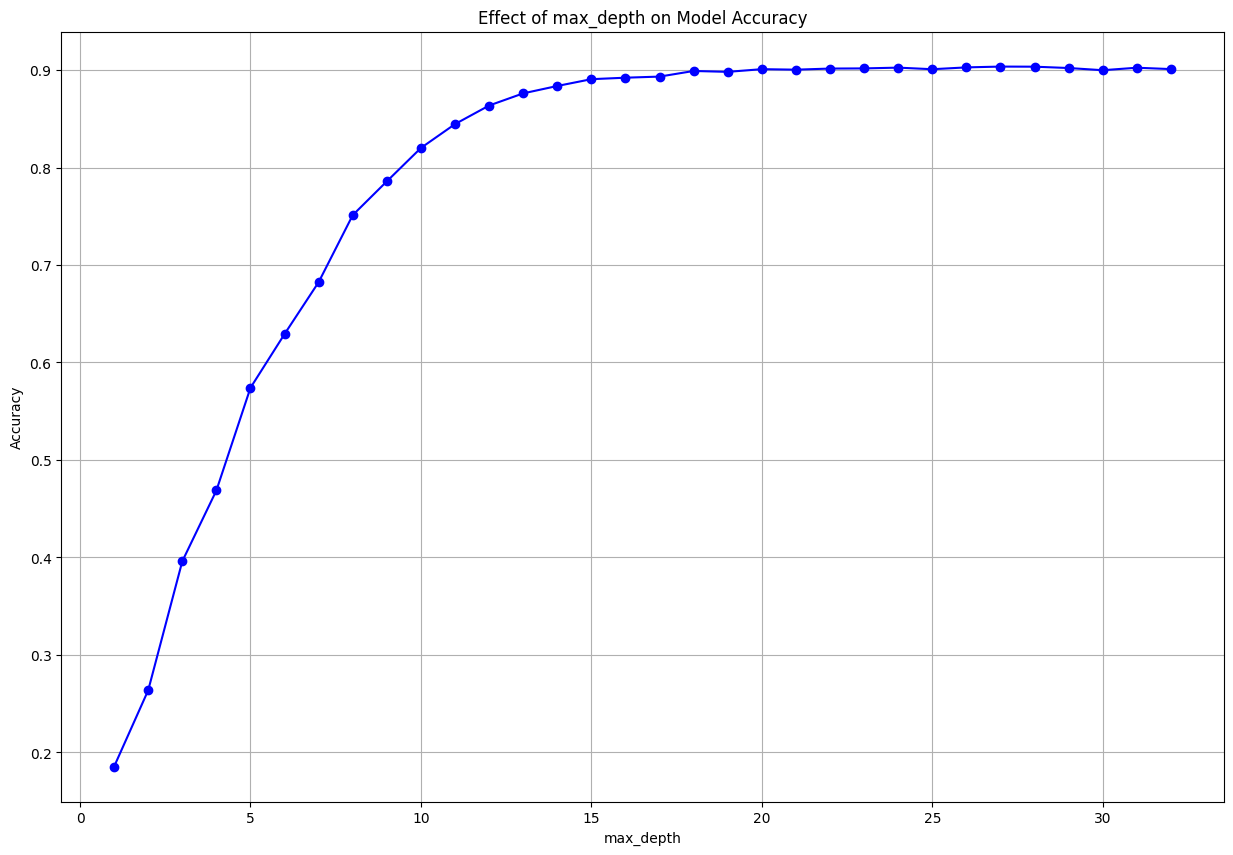

In [106]:
district_max_depth_params, district_max_depth_accs = graph_parameter(district_training_datasets, district_testing_datasets, 'max_depth', 1, -1, 1, min_iteration=20, tolerance=0.01, max_tolerable_changes=10)

[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   25.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.2510% found for parameter min_samples_split at 2


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   25.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.1642% found for parameter min_samples_split at 4


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   25.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.0406% found for parameter min_samples_split at 6


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   25.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.5214% found for parameter min_samples_split at 8


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   24.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.2843% found for parameter min_samples_split at 10


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   24.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.2062% found for parameter min_samples_split at 12


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   25.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.3747% found for parameter min_samples_split at 14


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   25.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.0239% found for parameter min_samples_split at 16


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   24.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.0030% found for parameter min_samples_split at 18


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   25.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.0579% found for parameter min_samples_split at 20


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   25.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.0962% found for parameter min_samples_split at 22


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   24.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.0580% found for parameter min_samples_split at 24


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   24.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.2498% found for parameter min_samples_split at 26


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   24.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.8536% found for parameter min_samples_split at 28


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   24.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.7867% found for parameter min_samples_split at 30


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   24.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.0270% found for parameter min_samples_split at 32


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   25.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.9654% found for parameter min_samples_split at 34


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   26.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.6722% found for parameter min_samples_split at 36


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   25.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.7129% found for parameter min_samples_split at 38


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   25.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.6742% found for parameter min_samples_split at 40


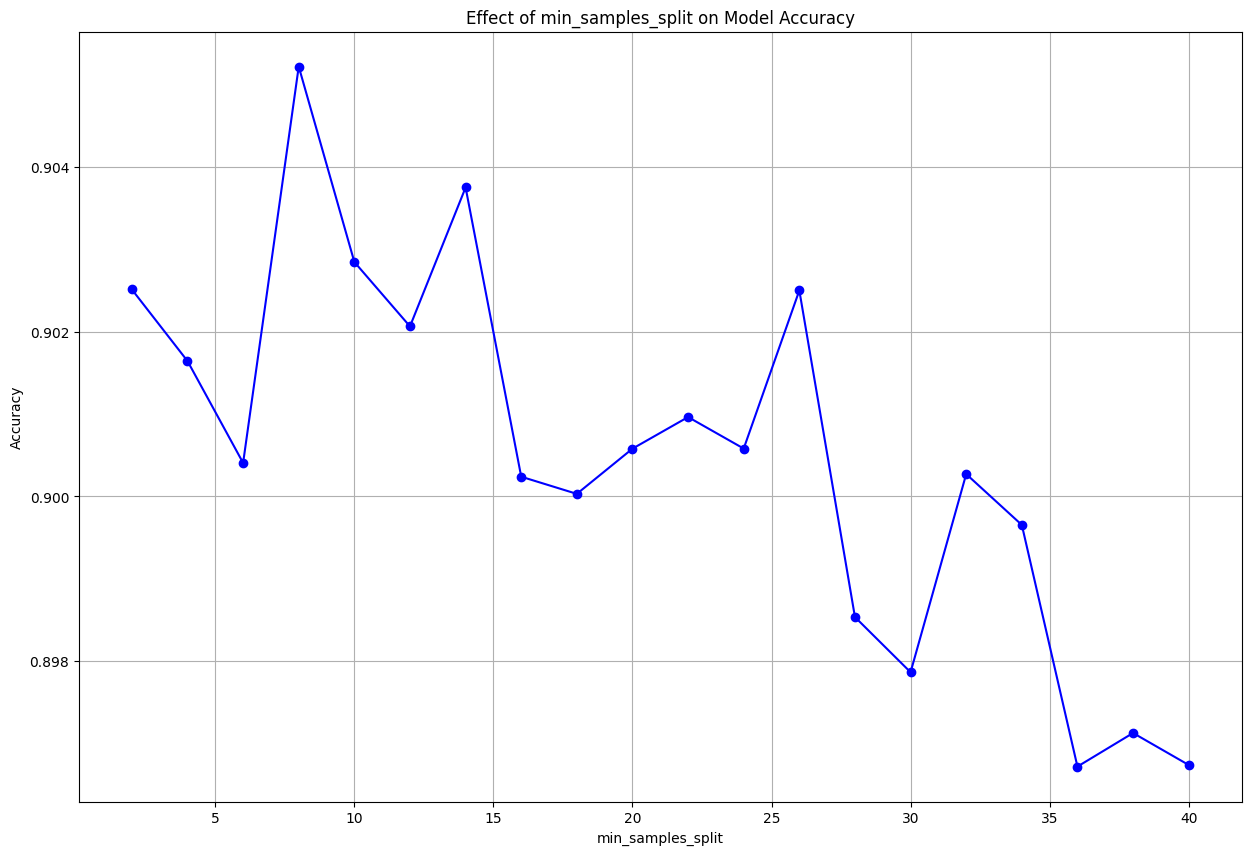

In [107]:
district_min_samples_split_params, district_min_samples_split_accs = graph_parameter(district_training_datasets, district_testing_datasets, 'min_samples_split', 2, -1, 2, min_iteration=15, tolerance=0.01, max_tolerable_changes=3)

[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    5.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 18.5316% found for parameter max_leaf_nodes at 2


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    2.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   11.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 62.2990% found for parameter max_leaf_nodes at 22


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    2.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   13.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 68.6084% found for parameter max_leaf_nodes at 42


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    2.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   14.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 73.4152% found for parameter max_leaf_nodes at 62


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    2.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   14.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 75.7787% found for parameter max_leaf_nodes at 82


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   15.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 77.0412% found for parameter max_leaf_nodes at 102


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   15.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 78.3475% found for parameter max_leaf_nodes at 122


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   16.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 79.1928% found for parameter max_leaf_nodes at 142


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   15.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 80.5105% found for parameter max_leaf_nodes at 162


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   15.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 81.0402% found for parameter max_leaf_nodes at 182


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   16.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 81.4603% found for parameter max_leaf_nodes at 202


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   16.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 81.4385% found for parameter max_leaf_nodes at 222


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   16.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 81.8422% found for parameter max_leaf_nodes at 242


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   17.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 82.7350% found for parameter max_leaf_nodes at 262


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   17.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 82.7303% found for parameter max_leaf_nodes at 282


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   17.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 83.0415% found for parameter max_leaf_nodes at 302


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   16.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 83.0057% found for parameter max_leaf_nodes at 322


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   16.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.1157% found for parameter max_leaf_nodes at 342


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   17.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.2939% found for parameter max_leaf_nodes at 362


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   17.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.5633% found for parameter max_leaf_nodes at 382


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   18.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.6755% found for parameter max_leaf_nodes at 402


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   18.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.8213% found for parameter max_leaf_nodes at 422


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   19.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.8381% found for parameter max_leaf_nodes at 442


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   18.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.9038% found for parameter max_leaf_nodes at 462


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   18.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.1758% found for parameter max_leaf_nodes at 482


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   18.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.5612% found for parameter max_leaf_nodes at 502


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   19.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.7584% found for parameter max_leaf_nodes at 522


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   18.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.7970% found for parameter max_leaf_nodes at 542


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   18.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.9883% found for parameter max_leaf_nodes at 562


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   18.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.1065% found for parameter max_leaf_nodes at 582


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   19.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.1716% found for parameter max_leaf_nodes at 602


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   19.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.3179% found for parameter max_leaf_nodes at 622


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   19.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.5280% found for parameter max_leaf_nodes at 642


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   19.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.2822% found for parameter max_leaf_nodes at 662


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   17.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.6914% found for parameter max_leaf_nodes at 682


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   19.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.5959% found for parameter max_leaf_nodes at 702


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.8s


Accuracy of 86.4502% found for parameter max_leaf_nodes at 722


[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   18.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


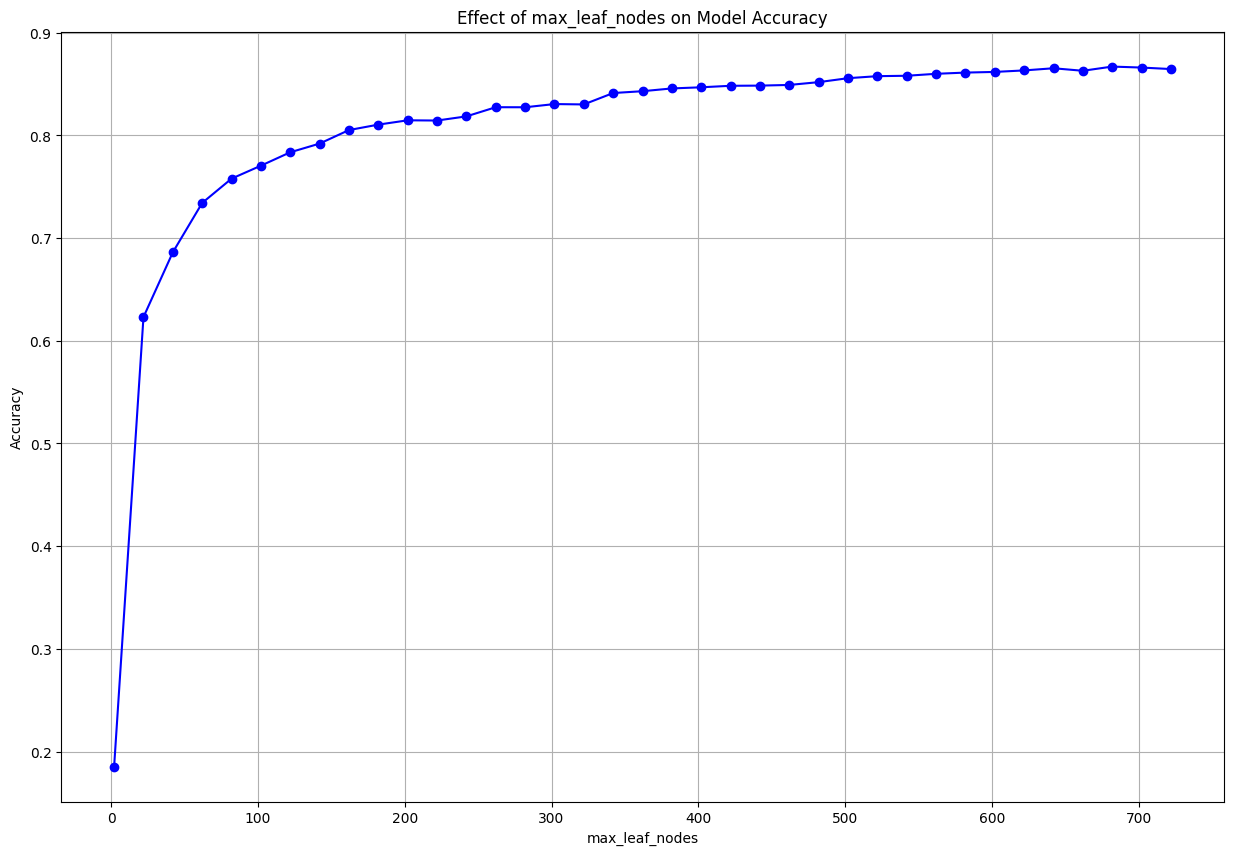

In [108]:
district_max_leaf_nodes_params, district_max_leaf_nodes_accs = graph_parameter(district_training_datasets, district_testing_datasets, 'max_leaf_nodes', 2, -1, 20, min_iteration=20, tolerance=0.01, max_tolerable_changes=15)

[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   19.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 87.0129% found for parameter max_leaf_nodes at 750


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   19.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 87.2328% found for parameter max_leaf_nodes at 800


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   19.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 86.9155% found for parameter max_leaf_nodes at 850


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   20.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 87.6235% found for parameter max_leaf_nodes at 900


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   19.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 87.6962% found for parameter max_leaf_nodes at 950


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   19.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 87.5250% found for parameter max_leaf_nodes at 1000


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   20.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 87.6993% found for parameter max_leaf_nodes at 1050


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   20.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 87.9435% found for parameter max_leaf_nodes at 1100


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 87.8805% found for parameter max_leaf_nodes at 1150


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   20.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.0953% found for parameter max_leaf_nodes at 1200


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 87.8306% found for parameter max_leaf_nodes at 1250


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.2186% found for parameter max_leaf_nodes at 1300


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 87.8339% found for parameter max_leaf_nodes at 1350


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.4436% found for parameter max_leaf_nodes at 1400


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.6676% found for parameter max_leaf_nodes at 1450


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.4484% found for parameter max_leaf_nodes at 1500


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   22.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.5956% found for parameter max_leaf_nodes at 1550


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.3853% found for parameter max_leaf_nodes at 1600


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   22.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.5192% found for parameter max_leaf_nodes at 1650


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.2s


Accuracy of 88.6481% found for parameter max_leaf_nodes at 1700


[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


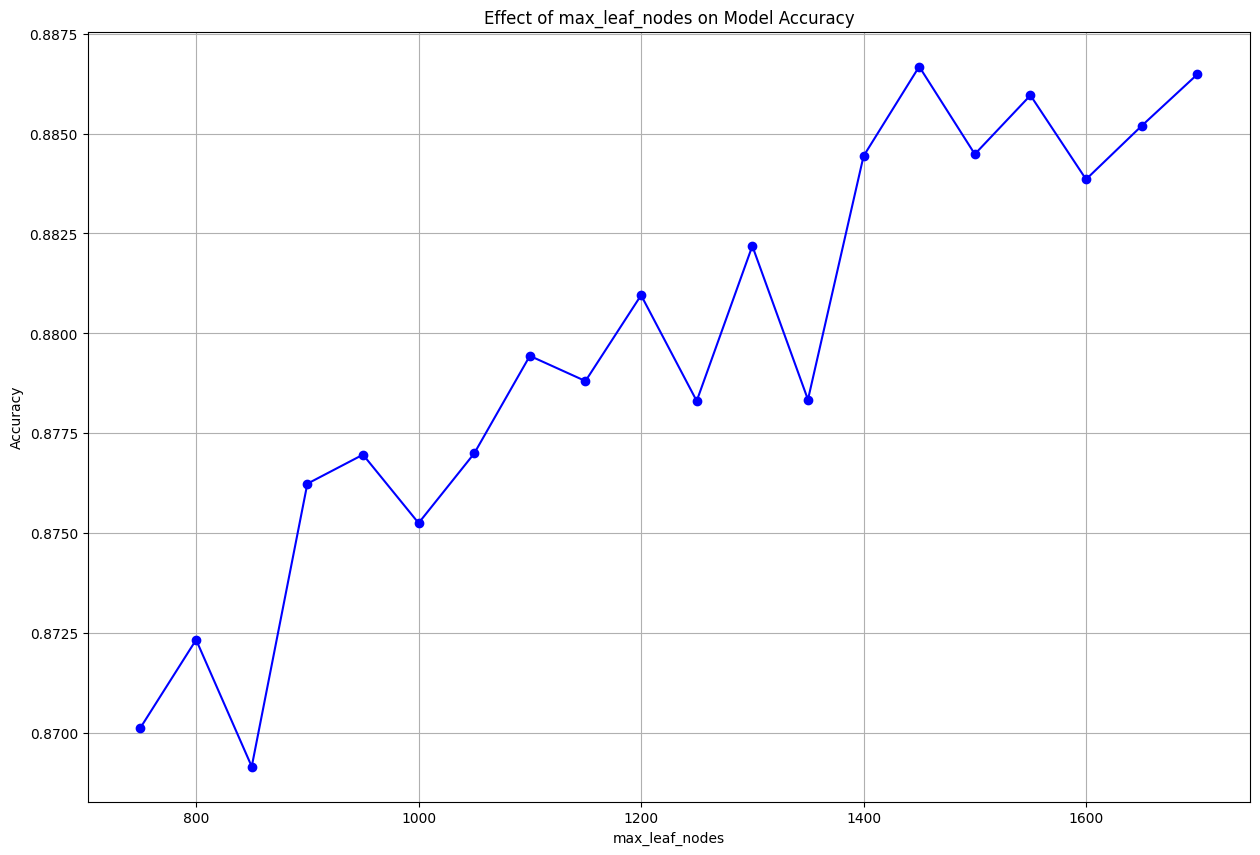

In [111]:
district_max_leaf_nodes_params_b, district_max_leaf_nodes_accs_b = graph_parameter(district_training_datasets, district_testing_datasets, 'max_leaf_nodes', 750, -1, 50, min_iteration=15)

[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   20.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.3147% found for parameter max_leaf_nodes at 1800


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.6160% found for parameter max_leaf_nodes at 1900


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   22.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.8350% found for parameter max_leaf_nodes at 2000


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   22.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.7230% found for parameter max_leaf_nodes at 2100


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   22.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.9223% found for parameter max_leaf_nodes at 2200


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   22.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.7507% found for parameter max_leaf_nodes at 2300


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   22.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.0289% found for parameter max_leaf_nodes at 2400


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   22.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.0005% found for parameter max_leaf_nodes at 2500


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   22.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.3961% found for parameter max_leaf_nodes at 2600


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   22.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.1035% found for parameter max_leaf_nodes at 2700


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   22.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.1077% found for parameter max_leaf_nodes at 2800


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   22.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.0194% found for parameter max_leaf_nodes at 2900


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   23.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.4213% found for parameter max_leaf_nodes at 3000


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   23.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.1704% found for parameter max_leaf_nodes at 3100


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   23.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.2263% found for parameter max_leaf_nodes at 3200


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   23.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.3353% found for parameter max_leaf_nodes at 3300


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   23.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.0940% found for parameter max_leaf_nodes at 3400


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   22.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.6482% found for parameter max_leaf_nodes at 3500


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   24.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.6518% found for parameter max_leaf_nodes at 3600


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.6s


Accuracy of 89.3043% found for parameter max_leaf_nodes at 3700


[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   24.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


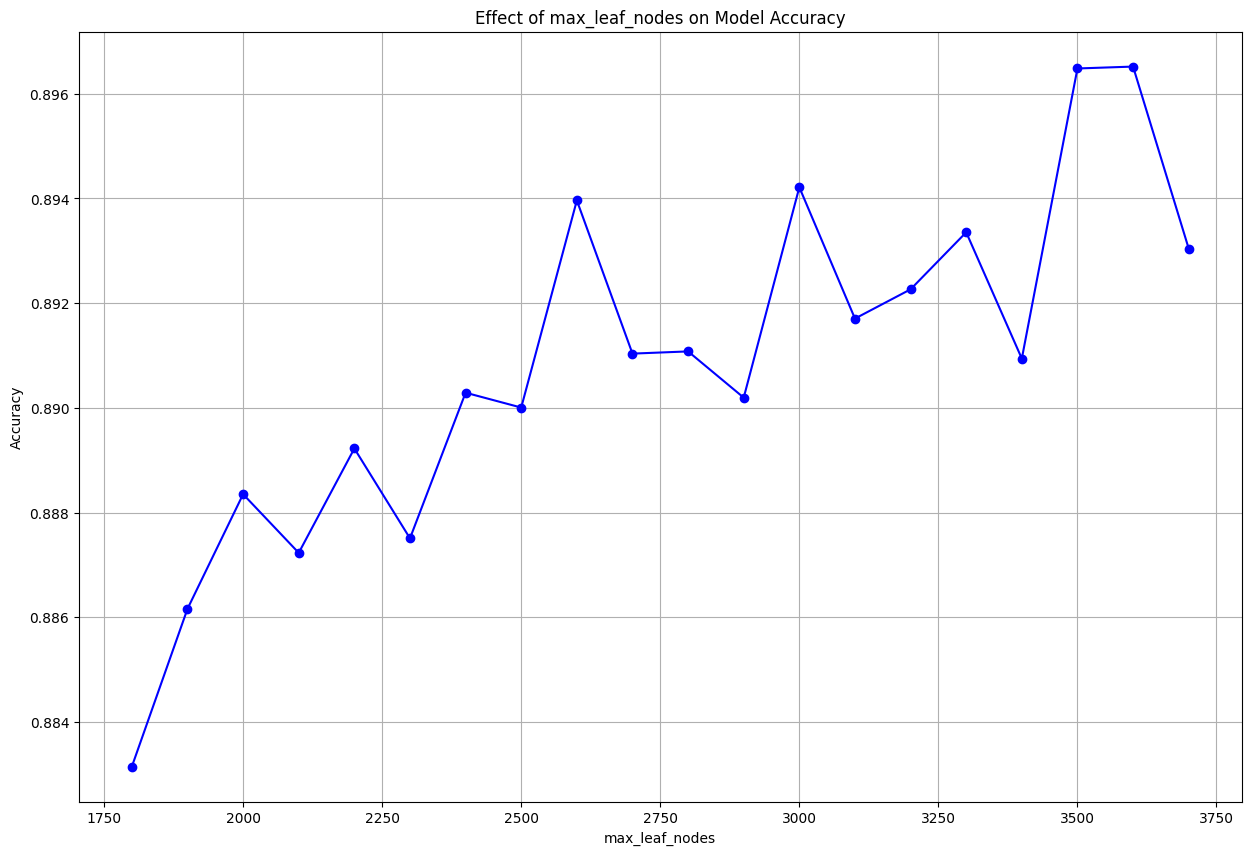

In [112]:
district_max_leaf_nodes_params_c, district_max_leaf_nodes_accs_c = graph_parameter(district_training_datasets, district_testing_datasets, 'max_leaf_nodes', 1800, -1, 100, min_iteration=15)

[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.4749% found for parameter max_leaf_nodes at 1800


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   20.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.1909% found for parameter max_leaf_nodes at 1900


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   20.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.8570% found for parameter max_leaf_nodes at 2000


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.9317% found for parameter max_leaf_nodes at 2100


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.9778% found for parameter max_leaf_nodes at 2200


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.9560% found for parameter max_leaf_nodes at 2300


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.7050% found for parameter max_leaf_nodes at 2400


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   20.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.8177% found for parameter max_leaf_nodes at 2500


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.1851% found for parameter max_leaf_nodes at 2600


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.2572% found for parameter max_leaf_nodes at 2700


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.0989% found for parameter max_leaf_nodes at 2800


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.3662% found for parameter max_leaf_nodes at 2900


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.3985% found for parameter max_leaf_nodes at 3000


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.0812% found for parameter max_leaf_nodes at 3100


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.3360% found for parameter max_leaf_nodes at 3200


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   22.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.3969% found for parameter max_leaf_nodes at 3300


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   22.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.4919% found for parameter max_leaf_nodes at 3400


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   22.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.2605% found for parameter max_leaf_nodes at 3500


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   22.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.3418% found for parameter max_leaf_nodes at 3600


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   22.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.3708% found for parameter max_leaf_nodes at 3700


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   22.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.1316% found for parameter max_leaf_nodes at 3800


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   22.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.4375% found for parameter max_leaf_nodes at 3900


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   22.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.6459% found for parameter max_leaf_nodes at 4000


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   22.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.7348% found for parameter max_leaf_nodes at 4100


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.5s


Accuracy of 89.5570% found for parameter max_leaf_nodes at 4200


[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   23.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


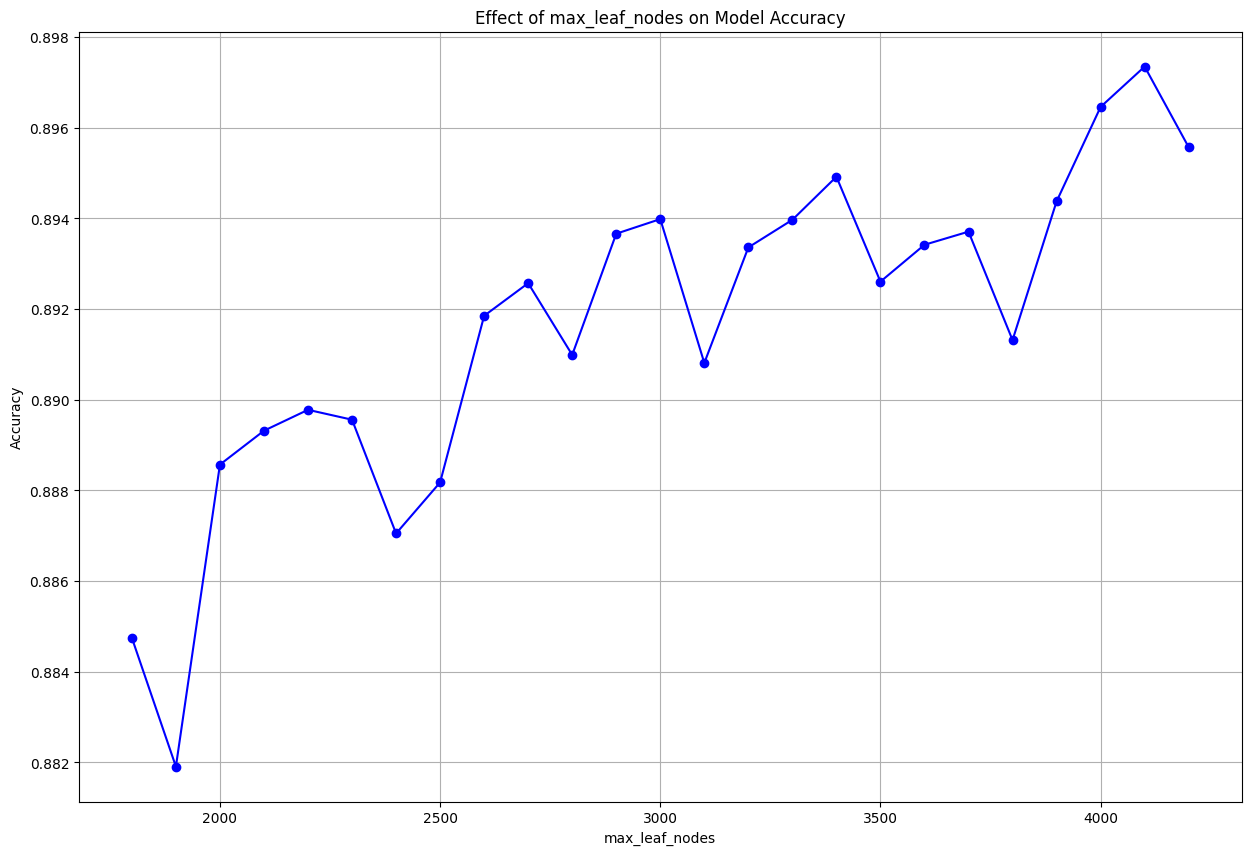

In [113]:
district_max_leaf_nodes_params_d, district_max_leaf_nodes_accs_d = graph_parameter(district_training_datasets, district_testing_datasets, 'max_leaf_nodes', 1800, -1, 100, min_iteration=20)

[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   24.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.5570% found for parameter max_leaf_nodes at 4200


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   23.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.8319% found for parameter max_leaf_nodes at 4300


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   23.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.4659% found for parameter max_leaf_nodes at 4400


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   23.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.2665% found for parameter max_leaf_nodes at 4500


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   23.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.8580% found for parameter max_leaf_nodes at 4600


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   22.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.6878% found for parameter max_leaf_nodes at 4700


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   23.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.3954% found for parameter max_leaf_nodes at 4800


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   23.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.7232% found for parameter max_leaf_nodes at 4900


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   23.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.7593% found for parameter max_leaf_nodes at 5000


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   23.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.7269% found for parameter max_leaf_nodes at 5100


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   23.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.5954% found for parameter max_leaf_nodes at 5200


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   24.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.8248% found for parameter max_leaf_nodes at 5300


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   23.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.8132% found for parameter max_leaf_nodes at 5400


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   23.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.7188% found for parameter max_leaf_nodes at 5500


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   23.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.7587% found for parameter max_leaf_nodes at 5600


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   22.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.8632% found for parameter max_leaf_nodes at 5700


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   23.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.7291% found for parameter max_leaf_nodes at 5800


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   23.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.6590% found for parameter max_leaf_nodes at 5900


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   24.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.9477% found for parameter max_leaf_nodes at 6000


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   24.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.0192% found for parameter max_leaf_nodes at 6100


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   24.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.8819% found for parameter max_leaf_nodes at 6200


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   23.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.8633% found for parameter max_leaf_nodes at 6300


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   24.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.8526% found for parameter max_leaf_nodes at 6400


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   24.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.8690% found for parameter max_leaf_nodes at 6500


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   24.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.9537% found for parameter max_leaf_nodes at 6600


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   24.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.9626% found for parameter max_leaf_nodes at 6700


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   24.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.9601% found for parameter max_leaf_nodes at 6800


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   24.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.9859% found for parameter max_leaf_nodes at 6900


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   23.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.8801% found for parameter max_leaf_nodes at 7000


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   24.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.9591% found for parameter max_leaf_nodes at 7100


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   24.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 90.0358% found for parameter max_leaf_nodes at 7200


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   25.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.9629% found for parameter max_leaf_nodes at 7300


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   24.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.7700% found for parameter max_leaf_nodes at 7400


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   24.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.9049% found for parameter max_leaf_nodes at 7500


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   25.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.8868% found for parameter max_leaf_nodes at 7600


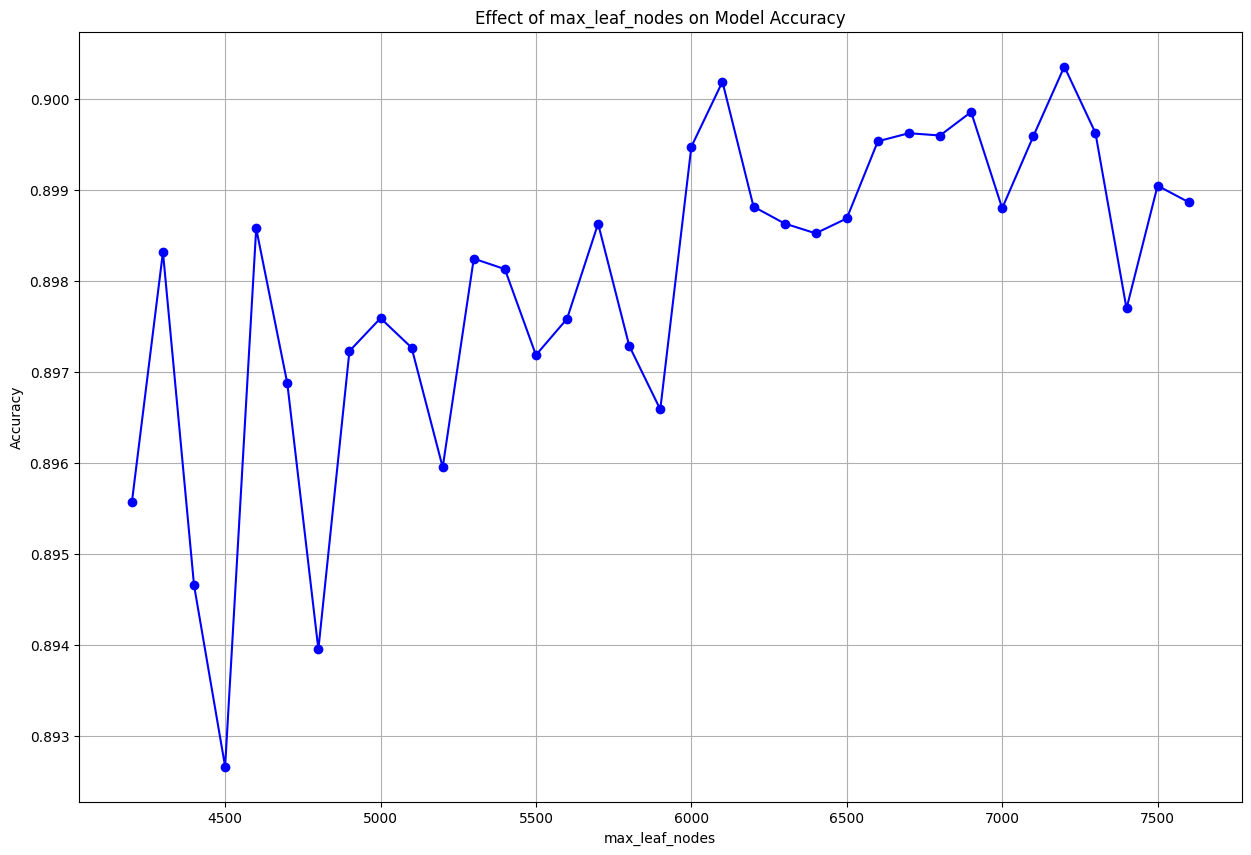

In [115]:
district_max_leaf_nodes_params_e, district_max_leaf_nodes_accs_e = graph_parameter(district_training_datasets, district_testing_datasets, 'max_leaf_nodes', 4200, -1, 100, min_iteration=30)

[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   25.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.7653% found for parameter max_leaf_nodes at 7800


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   26.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.0859% found for parameter max_leaf_nodes at 8000


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   26.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.0217% found for parameter max_leaf_nodes at 8200


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   25.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.0589% found for parameter max_leaf_nodes at 8400


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   25.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.8810% found for parameter max_leaf_nodes at 8600


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   27.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.1259% found for parameter max_leaf_nodes at 8800


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   26.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.9593% found for parameter max_leaf_nodes at 9000


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   26.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.2053% found for parameter max_leaf_nodes at 9200


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   26.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.0272% found for parameter max_leaf_nodes at 9400


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   26.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.8640% found for parameter max_leaf_nodes at 9600


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   27.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.9791% found for parameter max_leaf_nodes at 9800


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   26.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.9439% found for parameter max_leaf_nodes at 10000


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   26.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.0420% found for parameter max_leaf_nodes at 10200


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   26.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.0680% found for parameter max_leaf_nodes at 10400


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   26.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.0278% found for parameter max_leaf_nodes at 10600


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   27.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.2741% found for parameter max_leaf_nodes at 10800


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   27.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.3363% found for parameter max_leaf_nodes at 11000


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   28.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.0267% found for parameter max_leaf_nodes at 11200


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   26.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.1170% found for parameter max_leaf_nodes at 11400


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   26.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.2073% found for parameter max_leaf_nodes at 11600


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   28.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.1654% found for parameter max_leaf_nodes at 11800


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   27.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 90.0006% found for parameter max_leaf_nodes at 12000


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   28.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.1776% found for parameter max_leaf_nodes at 12200


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   28.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.3118% found for parameter max_leaf_nodes at 12400


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   28.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.1719% found for parameter max_leaf_nodes at 12600


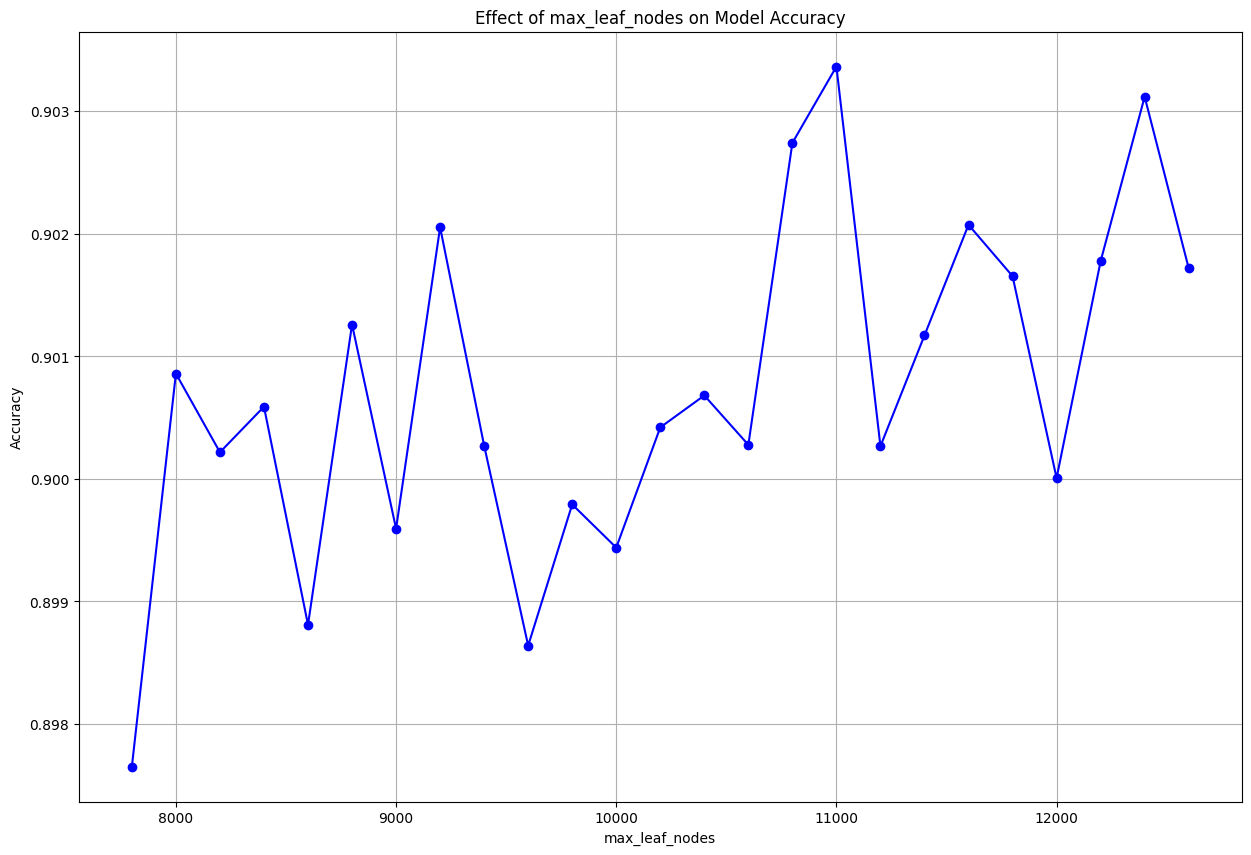

In [116]:
district_max_leaf_nodes_params_f, district_max_leaf_nodes_accs_f = graph_parameter(district_training_datasets, district_testing_datasets, 'max_leaf_nodes', 7800, -1, 200, min_iteration=20)

[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   28.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.1422% found for parameter max_leaf_nodes at 12600


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   28.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.8409% found for parameter max_leaf_nodes at 13000


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   28.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.2472% found for parameter max_leaf_nodes at 13400


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   28.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.1374% found for parameter max_leaf_nodes at 13800


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   27.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.2194% found for parameter max_leaf_nodes at 14200


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   27.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.1993% found for parameter max_leaf_nodes at 14600


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   28.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.0482% found for parameter max_leaf_nodes at 15000


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   27.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.0542% found for parameter max_leaf_nodes at 15400


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   28.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.4192% found for parameter max_leaf_nodes at 15800


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   29.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.9413% found for parameter max_leaf_nodes at 16200


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   29.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.2650% found for parameter max_leaf_nodes at 16600


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   29.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.1656% found for parameter max_leaf_nodes at 17000


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   29.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.4066% found for parameter max_leaf_nodes at 17400


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   29.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.4576% found for parameter max_leaf_nodes at 17800


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   29.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.1766% found for parameter max_leaf_nodes at 18200


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   29.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.1s finished


Accuracy of 90.0737% found for parameter max_leaf_nodes at 18600


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   29.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.1746% found for parameter max_leaf_nodes at 19000


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    6.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   30.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.2344% found for parameter max_leaf_nodes at 19400


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   30.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.8280% found for parameter max_leaf_nodes at 19800


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    6.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   30.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.1825% found for parameter max_leaf_nodes at 20200


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    6.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   30.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.0659% found for parameter max_leaf_nodes at 20600


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    6.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   30.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.0809% found for parameter max_leaf_nodes at 21000


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   30.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.1s finished


Accuracy of 90.0374% found for parameter max_leaf_nodes at 21400


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   30.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.4668% found for parameter max_leaf_nodes at 21800


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   30.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.1549% found for parameter max_leaf_nodes at 22200


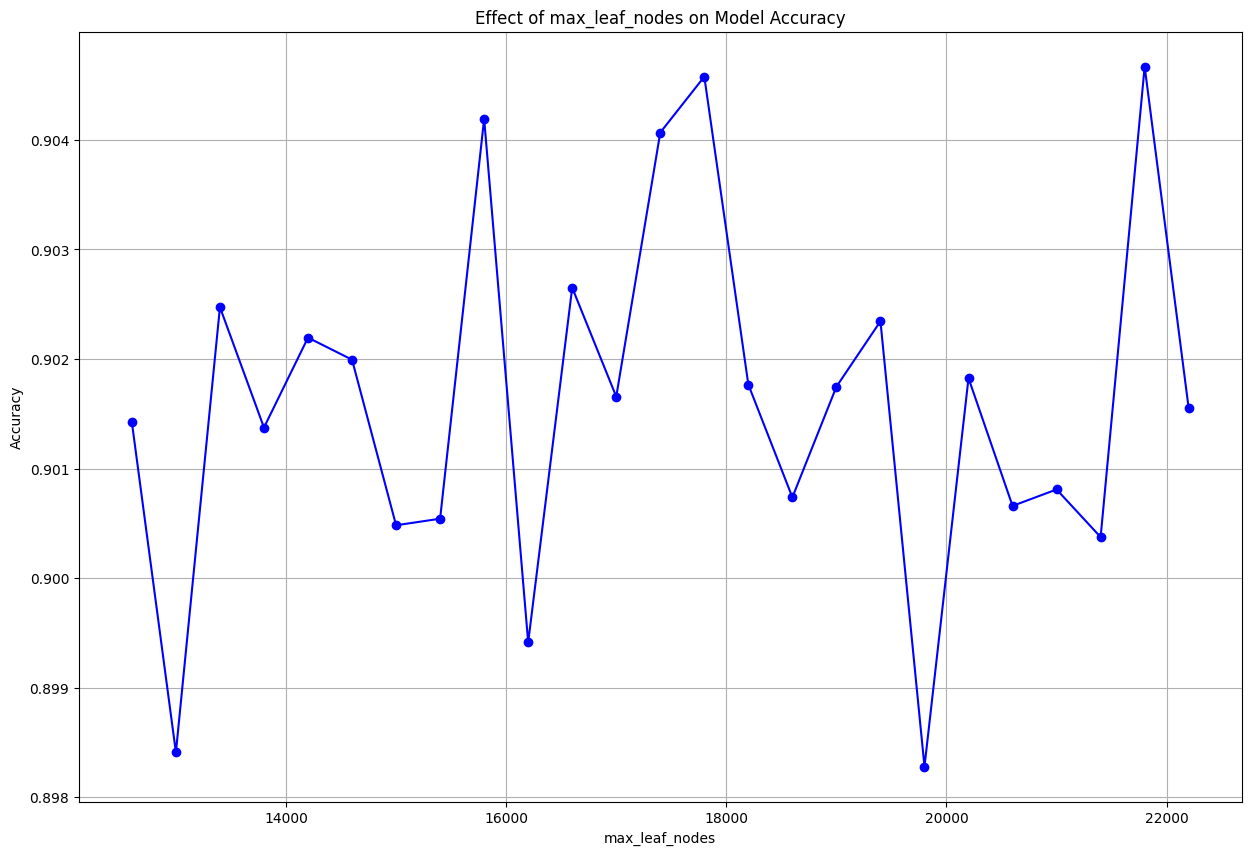

In [118]:
district_max_leaf_nodes_params_g, district_max_leaf_nodes_accs_g = graph_parameter(district_training_datasets, district_testing_datasets, 'max_leaf_nodes', 12600, -1, 400, min_iteration=20)

[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   25.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.0905% found for parameter min_samples_leaf at 1


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.6s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   23.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 88.1910% found for parameter min_samples_leaf at 11


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   23.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 86.9624% found for parameter min_samples_leaf at 21


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 86.3249% found for parameter min_samples_leaf at 31


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   22.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 85.5644% found for parameter min_samples_leaf at 41


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   22.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 85.2833% found for parameter min_samples_leaf at 51


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.7976% found for parameter min_samples_leaf at 61


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 84.3180% found for parameter min_samples_leaf at 71


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.0285% found for parameter min_samples_leaf at 81


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 83.2842% found for parameter min_samples_leaf at 91


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   20.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 83.0744% found for parameter min_samples_leaf at 101


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   20.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 83.2567% found for parameter min_samples_leaf at 111


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   20.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 83.0695% found for parameter min_samples_leaf at 121


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   20.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 82.7526% found for parameter min_samples_leaf at 131


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 82.2116% found for parameter min_samples_leaf at 141


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   20.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 82.0896% found for parameter min_samples_leaf at 151


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   20.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 81.8938% found for parameter min_samples_leaf at 161


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   20.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 81.4524% found for parameter min_samples_leaf at 171


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   20.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 81.1601% found for parameter min_samples_leaf at 181


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.8s


Accuracy of 81.2152% found for parameter min_samples_leaf at 191


[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   20.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


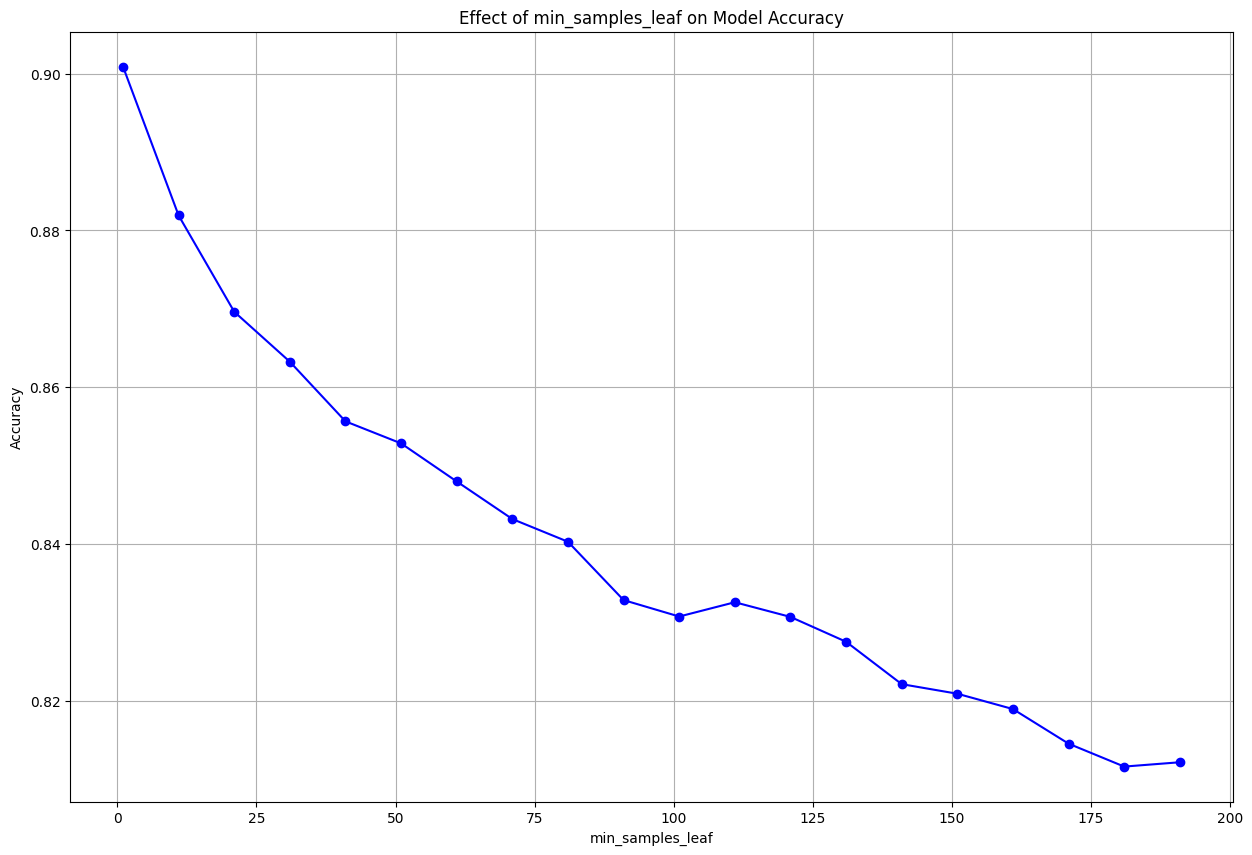

In [119]:
district_min_samples_leaf_params, district_min_samples_leaf_accs = graph_parameter(district_training_datasets, district_testing_datasets, 'min_samples_leaf', 1, -1, 10, min_iteration=15)

[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 81.4364% found for parameter n_estimators at 1


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  16 out of  16 | elapsed:    5.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.3116% found for parameter n_estimators at 16


[Parallel(n_jobs=18)]: Done  28 out of  31 | elapsed:    9.0s remaining:    0.9s
[Parallel(n_jobs=18)]: Done  31 out of  31 | elapsed:    9.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  28 out of  31 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=18)]: Done  31 out of  31 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.9112% found for parameter n_estimators at 31


[Parallel(n_jobs=18)]: Done  46 out of  46 | elapsed:   13.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  46 out of  46 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.7553% found for parameter n_estimators at 46


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.2s
[Parallel(n_jobs=18)]: Done  61 out of  61 | elapsed:   17.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.8441% found for parameter n_estimators at 61


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=18)]: Done  76 out of  76 | elapsed:   20.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done  76 out of  76 | elapsed:    0.0s finished


Accuracy of 90.2485% found for parameter n_estimators at 76


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.0s
[Parallel(n_jobs=18)]: Done  91 out of  91 | elapsed:   24.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done  91 out of  91 | elapsed:    0.0s finished


Accuracy of 90.1050% found for parameter n_estimators at 91


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.4s
[Parallel(n_jobs=18)]: Done 106 out of 106 | elapsed:   27.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 106 out of 106 | elapsed:    0.1s finished


Accuracy of 90.1895% found for parameter n_estimators at 106


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.1s
[Parallel(n_jobs=18)]: Done 121 out of 121 | elapsed:   31.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 121 out of 121 | elapsed:    0.1s finished


Accuracy of 90.2280% found for parameter n_estimators at 121


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.8s
[Parallel(n_jobs=18)]: Done 136 out of 136 | elapsed:   37.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 136 out of 136 | elapsed:    0.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 90.2773% found for parameter n_estimators at 136


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.4s
[Parallel(n_jobs=18)]: Done 151 out of 151 | elapsed:   39.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 151 out of 151 | elapsed:    0.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 90.1562% found for parameter n_estimators at 151


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.9s
[Parallel(n_jobs=18)]: Done 166 out of 166 | elapsed:   43.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 166 out of 166 | elapsed:    0.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 90.2254% found for parameter n_estimators at 166


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.6s
[Parallel(n_jobs=18)]: Done 181 out of 181 | elapsed:   47.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 181 out of 181 | elapsed:    0.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 90.2657% found for parameter n_estimators at 181


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.5s
[Parallel(n_jobs=18)]: Done 196 out of 196 | elapsed:   51.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 196 out of 196 | elapsed:    0.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 90.1876% found for parameter n_estimators at 196


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   42.3s
[Parallel(n_jobs=18)]: Done 211 out of 211 | elapsed:   53.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 211 out of 211 | elapsed:    0.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 90.1809% found for parameter n_estimators at 211


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.8s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   44.8s
[Parallel(n_jobs=18)]: Done 226 out of 226 | elapsed:   59.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 226 out of 226 | elapsed:    0.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 90.3458% found for parameter n_estimators at 226


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.6s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   44.0s
[Parallel(n_jobs=18)]: Done 241 out of 241 | elapsed:  1.0min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 241 out of 241 | elapsed:    0.2s finished


Accuracy of 90.1649% found for parameter n_estimators at 241


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.1s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   41.8s
[Parallel(n_jobs=18)]: Done 256 out of 256 | elapsed:  1.1min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 256 out of 256 | elapsed:    0.3s finished


Accuracy of 90.2371% found for parameter n_estimators at 256


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    6.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   43.8s
[Parallel(n_jobs=18)]: Done 271 out of 271 | elapsed:  1.2min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 271 out of 271 | elapsed:    0.3s finished


Accuracy of 90.0351% found for parameter n_estimators at 271


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.4s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   43.5s
[Parallel(n_jobs=18)]: Done 286 out of 286 | elapsed:  1.2min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 286 out of 286 | elapsed:    0.3s finished


Accuracy of 90.3180% found for parameter n_estimators at 286


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.8s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   43.9s
[Parallel(n_jobs=18)]: Done 301 out of 301 | elapsed:  1.3min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 301 out of 301 | elapsed:    0.3s finished


Accuracy of 90.0842% found for parameter n_estimators at 301


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.8s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   42.7s
[Parallel(n_jobs=18)]: Done 316 out of 316 | elapsed:  1.3min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 316 out of 316 | elapsed:    0.3s finished


Accuracy of 90.1862% found for parameter n_estimators at 316


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.1s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   42.8s
[Parallel(n_jobs=18)]: Done 331 out of 331 | elapsed:  1.4min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 331 out of 331 | elapsed:    0.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 90.2975% found for parameter n_estimators at 331


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.8s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   40.0s
[Parallel(n_jobs=18)]: Done 346 out of 346 | elapsed:  1.3min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 346 out of 346 | elapsed:    0.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 90.4002% found for parameter n_estimators at 346


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.6s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   42.6s
[Parallel(n_jobs=18)]: Done 361 out of 361 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 361 out of 361 | elapsed:    0.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 90.2556% found for parameter n_estimators at 361


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   41.1s
[Parallel(n_jobs=18)]: Done 376 out of 376 | elapsed:  1.5min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 376 out of 376 | elapsed:    0.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 90.2449% found for parameter n_estimators at 376


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.2s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   44.7s
[Parallel(n_jobs=18)]: Done 391 out of 391 | elapsed:  1.7min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 391 out of 391 | elapsed:    0.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 90.3404% found for parameter n_estimators at 391


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.8s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   42.9s
[Parallel(n_jobs=18)]: Done 406 out of 406 | elapsed:  1.7min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 406 out of 406 | elapsed:    0.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 90.1855% found for parameter n_estimators at 406


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   42.4s
[Parallel(n_jobs=18)]: Done 421 out of 421 | elapsed:  1.7min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 421 out of 421 | elapsed:    0.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 90.1467% found for parameter n_estimators at 421


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.8s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   42.2s
[Parallel(n_jobs=18)]: Done 436 out of 436 | elapsed:  1.8min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 436 out of 436 | elapsed:    0.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 90.2119% found for parameter n_estimators at 436


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.4s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   43.9s
[Parallel(n_jobs=18)]: Done 414 tasks      | elapsed:  1.8min
[Parallel(n_jobs=18)]: Done 451 out of 451 | elapsed:  2.0min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.1s
[Parallel(n_jobs=18)]: Done 414 tasks      | elapsed:    0.5s
[Parallel(n_jobs=18)]: Done 451 out of 451 | elapsed:    0.6s finished


Accuracy of 90.3029% found for parameter n_estimators at 451


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.9s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   42.0s
[Parallel(n_jobs=18)]: Done 414 tasks      | elapsed:  1.7min
[Parallel(n_jobs=18)]: Done 466 out of 466 | elapsed:  1.9min finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:    0.1s


Accuracy of 90.2518% found for parameter n_estimators at 466


[Parallel(n_jobs=18)]: Done 414 tasks      | elapsed:    0.5s
[Parallel(n_jobs=18)]: Done 466 out of 466 | elapsed:    0.6s finished


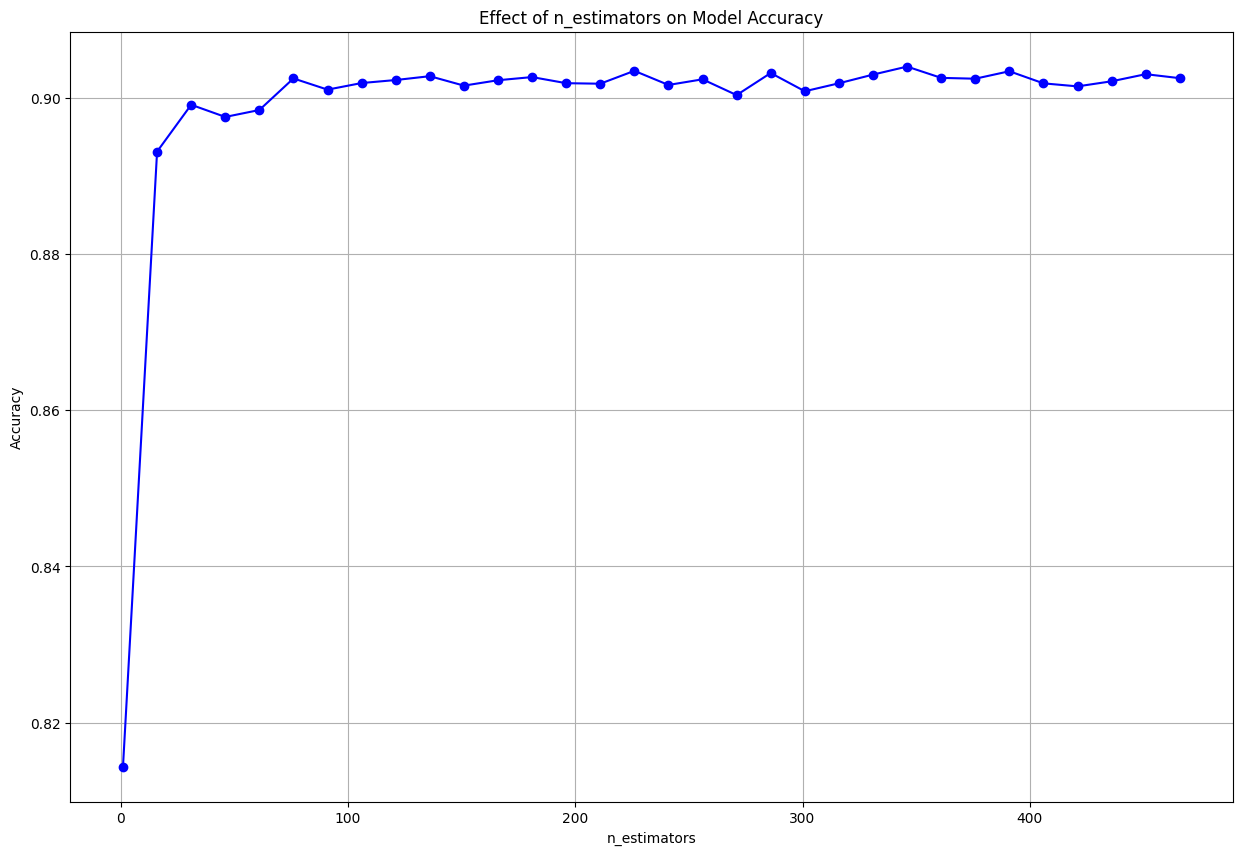

In [120]:
district_n_estimators_params, district_n_estimators_accs = graph_parameter(district_training_datasets, district_testing_datasets, 'n_estimators', 1, -1, 15, min_iteration=25, tolerance=0.01, max_tolerable_changes=5)

[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    3.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 80.0799% found for parameter max_features at 1


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    4.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 84.7984% found for parameter max_features at 2


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    1.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 87.4007% found for parameter max_features at 3


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    1.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    6.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 88.3036% found for parameter max_features at 4


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    1.5s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    7.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.1743% found for parameter max_features at 5


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    1.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    8.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.


Accuracy of 89.4952% found for parameter max_features at 6


[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    1.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    9.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.1s finished


Accuracy of 90.1351% found for parameter max_features at 7


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    2.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   10.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.1s finished


Accuracy of 90.3972% found for parameter max_features at 8


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    2.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   12.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.1s finished


Accuracy of 90.3461% found for parameter max_features at 9


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    2.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   12.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.1s finished


Accuracy of 90.2575% found for parameter max_features at 10


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    2.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   12.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.3387% found for parameter max_features at 11


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    2.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   14.4s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.1s finished


Accuracy of 90.9391% found for parameter max_features at 12


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   15.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.1s finished


Accuracy of 90.9867% found for parameter max_features at 13


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   16.7s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.1s finished


Accuracy of 90.6570% found for parameter max_features at 14


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   16.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.1s finished


Accuracy of 90.7879% found for parameter max_features at 15


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   17.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 91.0904% found for parameter max_features at 16


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   18.9s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.9977% found for parameter max_features at 17


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   19.6s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.9636% found for parameter max_features at 18


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    3.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   20.1s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.9873% found for parameter max_features at 19


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.3s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   21.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.9886% found for parameter max_features at 20


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   23.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.7484% found for parameter max_features at 21


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.8s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   24.0s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.7928% found for parameter max_features at 22


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.1s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   25.3s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.1s finished


Accuracy of 90.6178% found for parameter max_features at 23


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.2s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   25.5s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.1s finished


Accuracy of 90.6314% found for parameter max_features at 24


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    4.9s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   26.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 89.9509% found for parameter max_features at 25


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.7s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   26.8s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.4139% found for parameter max_features at 26


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    5.4s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:   27.2s finished
[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=18)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy of 90.0540% found for parameter max_features at 27


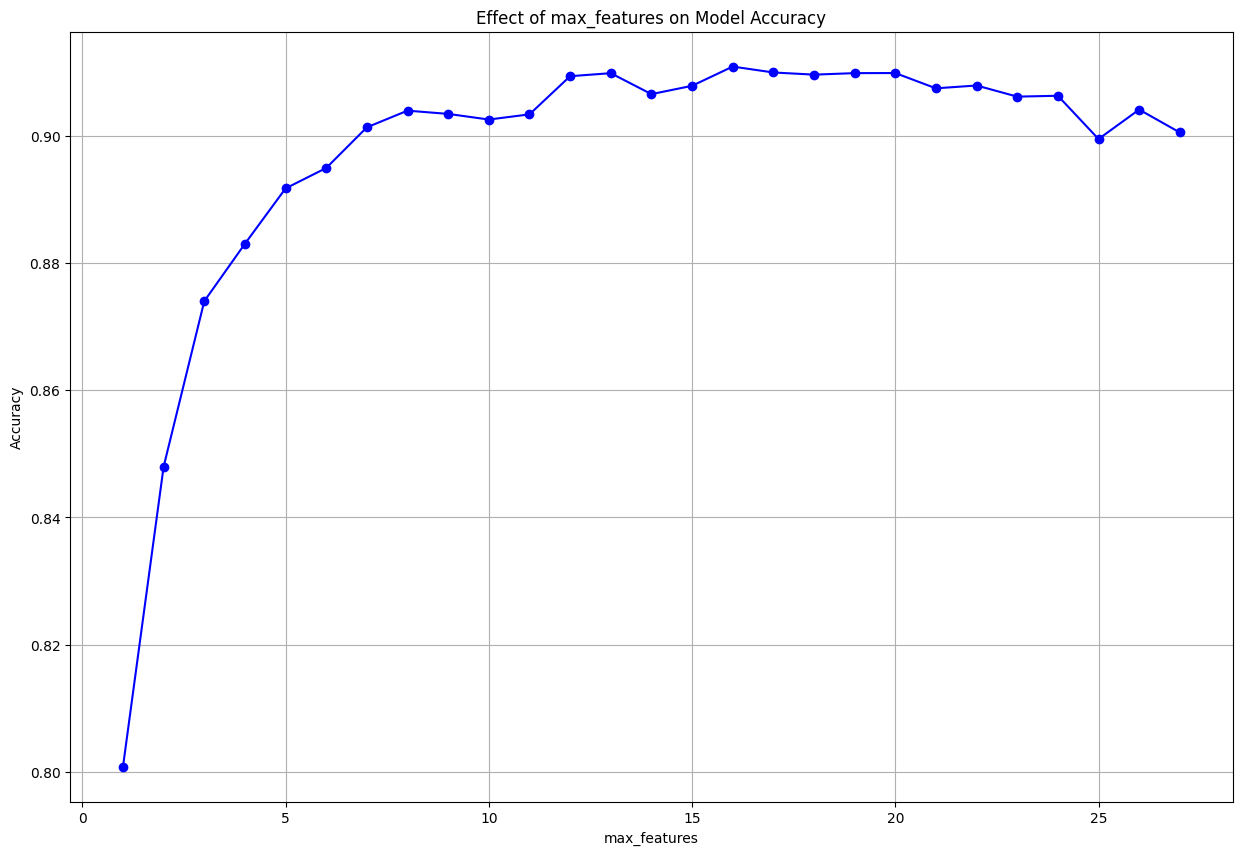

In [121]:
district_max_features_params, district_max_features_accs = graph_parameter(district_training_datasets, district_testing_datasets, 'max_features', 1, -1, 1, min_iteration=20, tolerance=0.01, max_tolerable_changes=5)

In [127]:
district_max_leaf_nodes_params = district_max_leaf_nodes_params + district_max_leaf_nodes_params_b + district_max_leaf_nodes_params_c + district_max_leaf_nodes_params_d + district_max_leaf_nodes_params_e + district_max_leaf_nodes_params_f + district_max_leaf_nodes_params_g
district_max_leaf_nodes_accs = district_max_leaf_nodes_accs + district_max_leaf_nodes_accs_b + district_max_leaf_nodes_accs_c + district_max_leaf_nodes_accs_d + district_max_leaf_nodes_accs_e + district_max_leaf_nodes_accs_f + district_max_leaf_nodes_accs_g

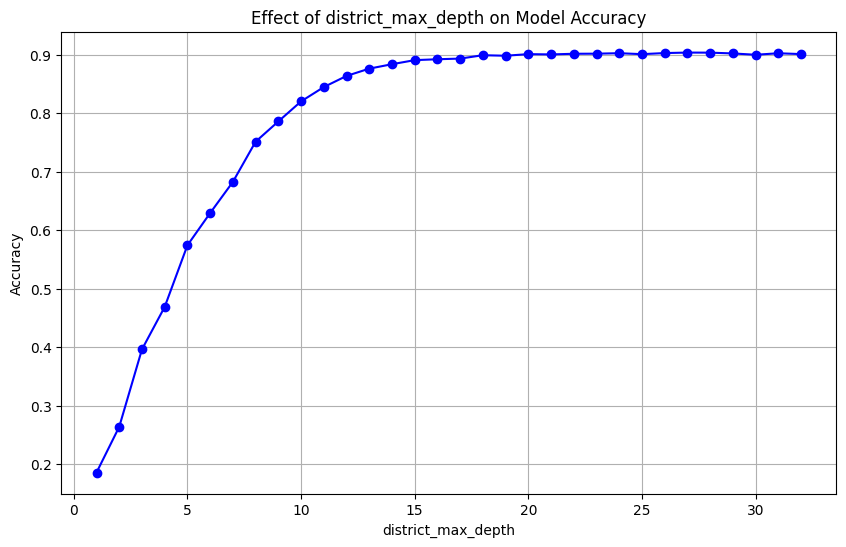

In [125]:
district_max_depth_df = save_fig(district_max_depth_params, district_max_depth_accs, title='district_max_depth', version='district')

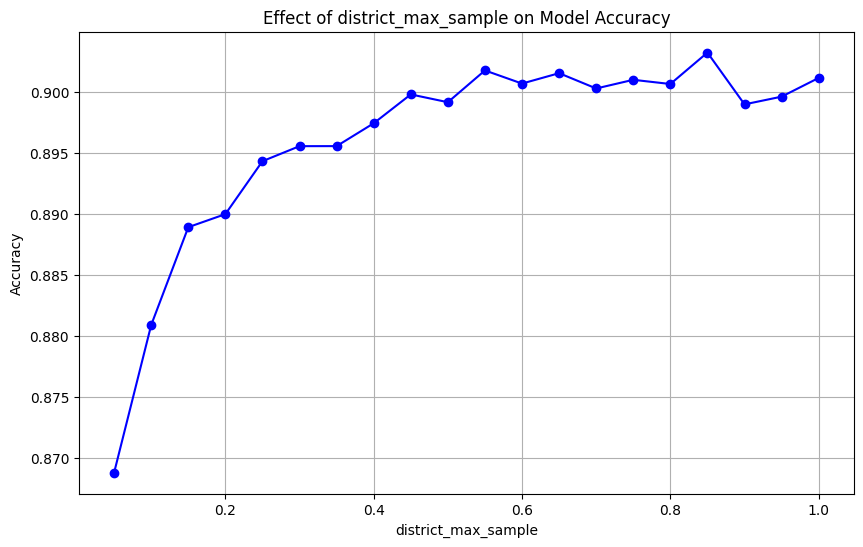

In [126]:
district_max_sample_df = save_fig(district_max_sample_params, district_max_sample_accs, title='district_max_sample', version='district')

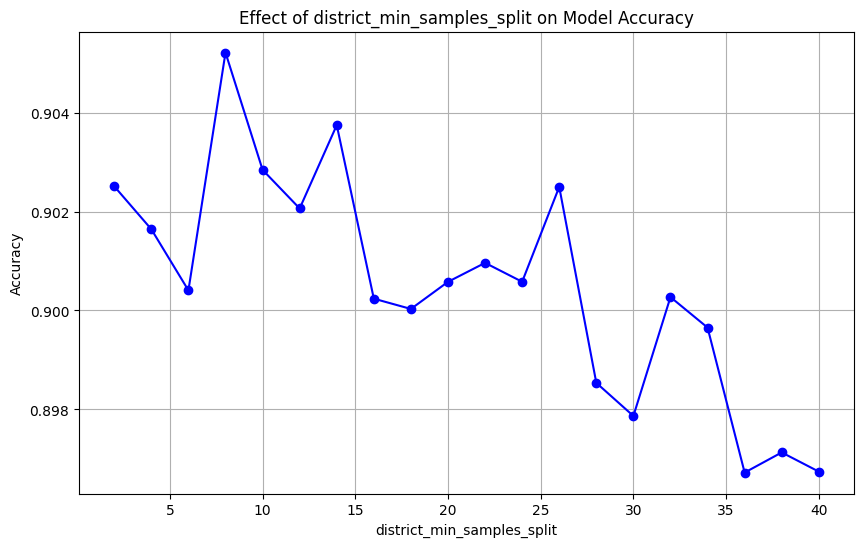

In [136]:
district_min_samples_split_df = save_fig(district_min_samples_split_params, district_min_samples_split_accs, title='district_min_samples_split', version='district')

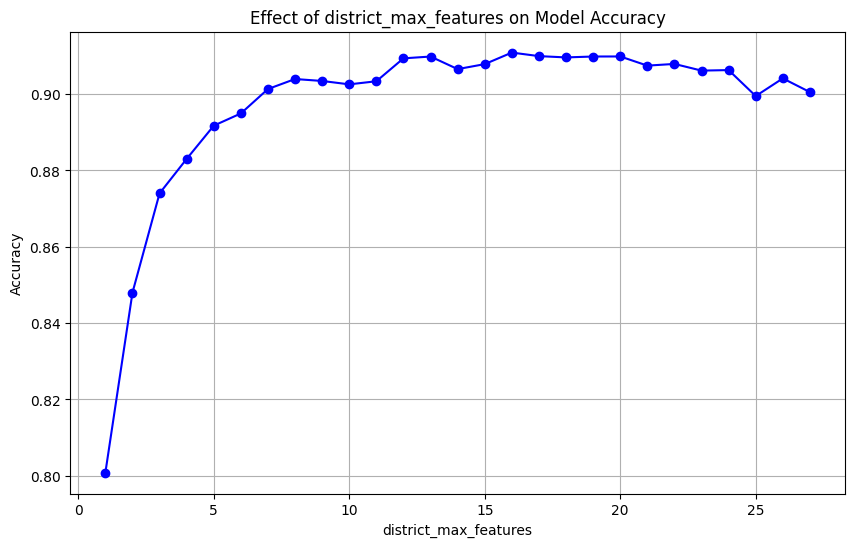

In [137]:
district_max_features_df = save_fig(district_max_features_params, district_max_features_accs, title='district_max_features', version='district')

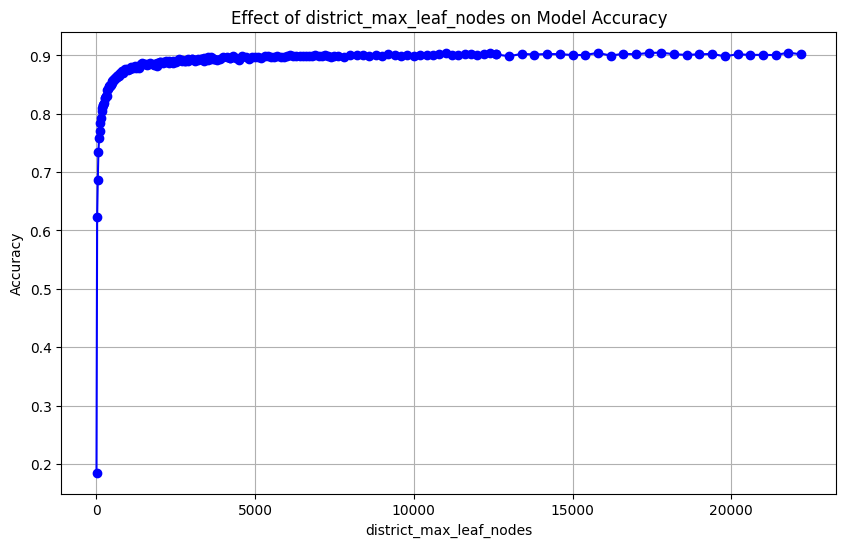

In [129]:
district_max_leaf_nodes_df = save_fig(district_max_leaf_nodes_params, district_max_leaf_nodes_accs, title='district_max_leaf_nodes', version='district')

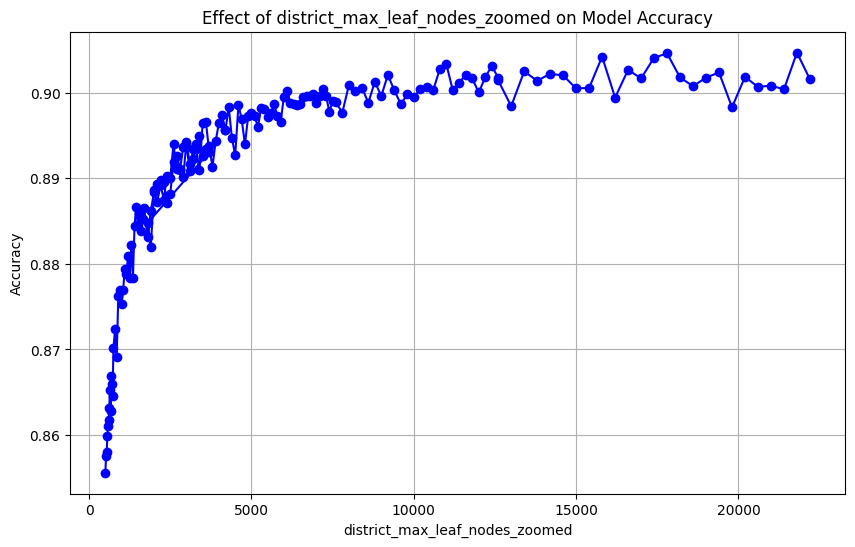

In [135]:
_ = save_fig(district_max_leaf_nodes_df[district_max_leaf_nodes_df['params'] >= 500]['params'].values, district_max_leaf_nodes_df[district_max_leaf_nodes_df['params'] >= 500]['accs'].values, title='district_max_leaf_nodes_zoomed', version='district')

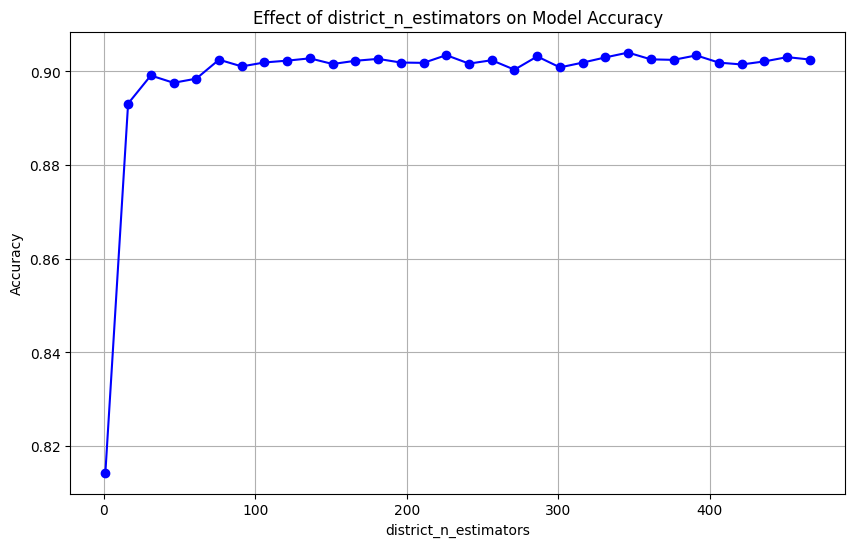

In [138]:
district_n_estimators_df = save_fig(district_n_estimators_params, district_n_estimators_accs, title='district_n_estimators', version='district')

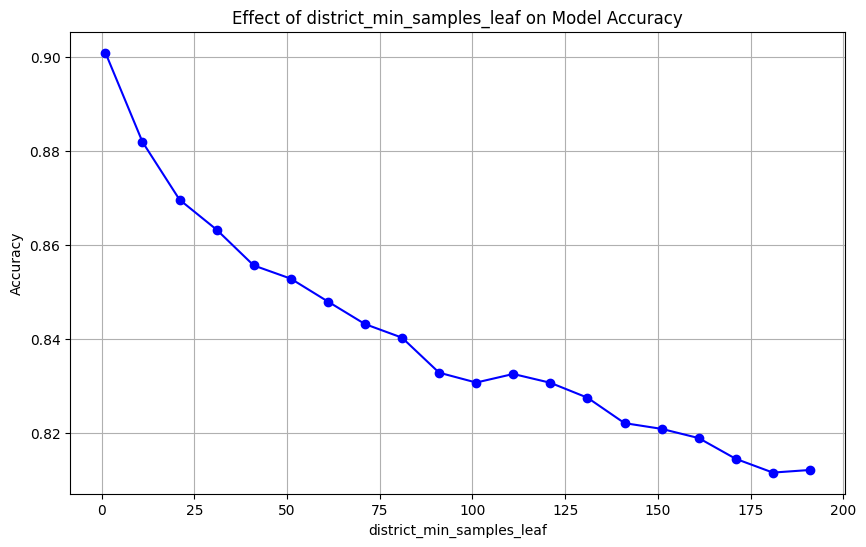

In [139]:
district_min_samples_leaf_df = save_fig(district_min_samples_leaf_params, district_min_samples_leaf_accs, title='district_min_samples_leaf', version='district')

##### Running Grid Search on Final Parameters for Area Model

In [150]:
area_param_grid = {
    'n_estimators': [25, 100],
    'max_features': [13, 16],
    'max_depth': [20, 25, None],
    'min_samples_split': [76, 82],
    'min_samples_leaf': [1, 2],
    'max_samples': [0.2, 0.3],
    'max_leaf_nodes':[3500, 4500, 5500, None]
}

In [151]:
rf_area_model = RandomForestRegressor(random_state=42)
grid_search_area = GridSearchCV(estimator=rf_area_model, param_grid=area_param_grid, cv=5, n_jobs=15, verbose=1, scoring='r2')

In [152]:
grid_search_area.fit(rf_area_stratified_feature_training_sample, rf_area_stratified_target_training_sample)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=15,
             param_grid={'max_depth': [20, 25, None], 'max_features': [13, 16],
                         'max_leaf_nodes': [3500, 4500, 5500, None],
                         'max_samples': [0.2, 0.3], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [76, 82],
                         'n_estimators': [25, 100]},
             scoring='r2', verbose=1)

In [153]:
best_params_area = grid_search_area.best_params_
best_score_area = grid_search_area.best_score_
print(f'Best Parameters for Area Model: {best_params_area}')
print(f'Best R2 Score for Area Model: {best_score_area:.4f}')

Best Parameters for Area Model: {'max_depth': None, 'max_features': 16, 'max_leaf_nodes': None, 'max_samples': 0.3, 'min_samples_leaf': 1, 'min_samples_split': 76, 'n_estimators': 100}
Best R2 Score for Area Model: 0.8995


##### Running Grid Search on Final Parameters for District Model

In [154]:
district_param_grid = {
    'n_estimators': [100, 300],
    'max_features': [16, 18],
    'max_depth': [20, None],
    'min_samples_split': [8],
    'min_samples_leaf': [1],
    'max_samples': [0.65, 0.85, None],
    'max_leaf_nodes':[12000, 17000, None]
}

In [155]:
rf_district_model = RandomForestRegressor(random_state=42)
grid_search_district = GridSearchCV(estimator=rf_district_model, param_grid=district_param_grid, cv=5, n_jobs=15, verbose=1, scoring='r2')

In [156]:
grid_search_district.fit(rf_district_stratified_feature_training_sample, rf_district_stratified_target_training_sample)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=15,
             param_grid={'max_depth': [20, None], 'max_features': [16, 18],
                         'max_leaf_nodes': [12000, 17000, None],
                         'max_samples': [0.65, 0.85, None],
                         'min_samples_leaf': [1], 'min_samples_split': [8],
                         'n_estimators': [100, 300]},
             scoring='r2', verbose=1)

In [157]:
best_params_district = grid_search_district.best_params_
best_score_district = grid_search_district.best_score_
print(f'Best Parameters for District Model: {best_params_district}')
print(f'Best R2 Score for District Model: {best_score_district:.4f}')

Best Parameters for District Model: {'max_depth': None, 'max_features': 18, 'max_leaf_nodes': None, 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 300}
Best R2 Score for District Model: 0.8041


##### Training the Final RF Models

In [243]:
def evaluate(model, test_features, test_labels):
    model.set_params(verbose=0)
    predictions = model.predict(test_features)
    errors = (predictions - test_labels) ** 2
    rmse = round(np.sqrt(np.mean(errors)), 6)

    # gathering insights into the data to better understand RMSE
    ma, mi, av = round(max(test_labels), 6), min(test_labels), round(np.mean(test_labels), 6)
    print('Model Ranges')
    print(f'Dataset Max: {ma} | Dataset Min: {mi} | Dataset Avg: {av}')
    print()
    print('Model Performance')
    print(f'RMSE: {rmse}')
    print(f'RMSE relative to data: {round(rmse / ma, 3) * 100}%')

In [158]:
final_rf_area_model = grid_search_area.best_estimator_
final_rf_area_model.set_params(n_jobs=15)
final_rf_area_model.set_params(verbose=1)
final_rf_area_model.fit(rf_area_feature_training_selected_data, rf_area_target_training_data)

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:   23.1s
[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:  1.3min finished


RandomForestRegressor(max_features=16, max_samples=0.3, min_samples_split=76,
                      n_jobs=15, random_state=42, verbose=1)

In [159]:
area_acc_final = final_rf_area_model.score(rf_area_feature_testing_selected_data, rf_area_target_testing_data)
print(f'Final Accuracy for Area Model after Hyperparameter Tuning: {area_acc_final:.4f}')

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.1s


Final Accuracy for Area Model after Hyperparameter Tuning: 0.9024


[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:    0.9s finished


In [250]:
for i, feature in enumerate(area_top_features):
    print(f'{feature}: {final_rf_area_model.feature_importances_[i]}')

bus_stops_distance_0.1: 0.2119138034664852
alleylights_distance_0.1: 0.15609481363089153
police_stations_distance_1: 0.056987813991470904
area_id_target_encoded: 0.05700418106883146
streetlights_allout_distance_0.5: 0.07508951347726346
streetlights_allout_distance_0.3: 0.05673071043888659
train_stations_distance_0.5: 0.03787513348499454
streetlights_oneout_distance_0.1: 0.03623593981392917
streetlights_oneout_distance_0.3: 0.09086033635361175
bike_rides_within_0.5_and_15_min: 0.026270749059572253
bike_stations_distance_0.1: 0.015245820660954385
bike_stations_distance_0.3: 0.01556649895934474
train_stations_distance_0.3: 0.020913629739604932
police_stations_distance_0.5: 0.01221731662383886
police_stations_distance_3: 0.008973724372244517
bike_rides_within_0.3_and_15_min: 0.00836738053847319
bus_stops_distance_1: 0.0058167693127791995
bus_stops_distance_0.3: 0.03025385709108102
train_stations_distance_0.1: 0.0034047553607343337
police_stations_distance_5: 0.007389899957651708
district_c

In [177]:
final_area_importances = final_rf_area_model.feature_importances_
final_area_feature_names = area_top_features

final_area_feature_importance_df = pd.DataFrame({'feature':final_area_feature_names, 'importance':final_area_importances})
final_area_feature_importance_df.sort_values(by='importance', ascending=False, inplace=True)

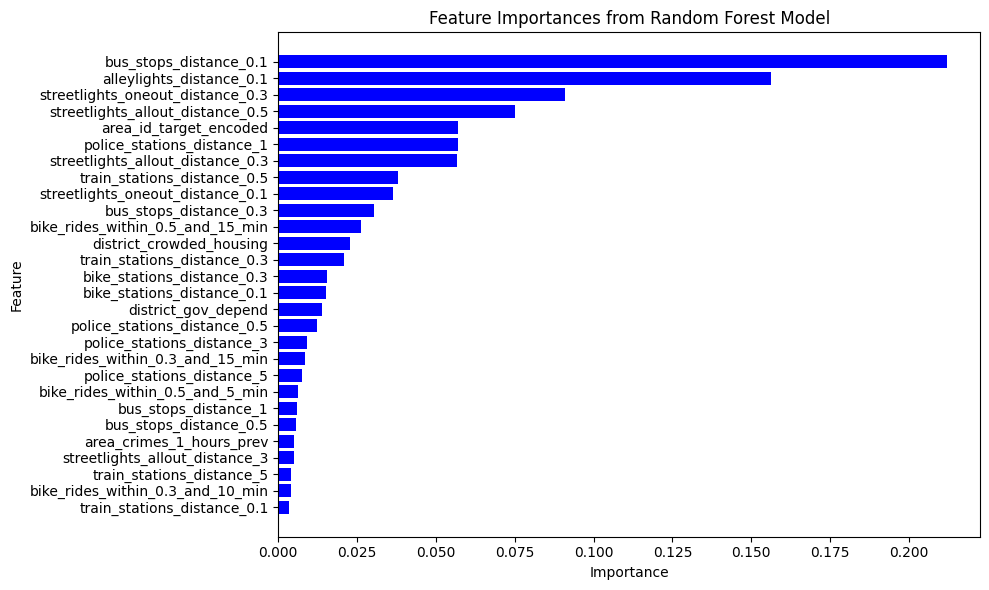

In [190]:
plt.figure(figsize=(10, 6))
plt.barh(final_area_feature_importance_df['feature'], final_area_feature_importance_df['importance'], color='b')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../results/random_forest/final_area_model_feature_importances.png')
plt.show()

In [ ]:
evaluate(final_rf_area_model, rf_area_feature_testing_selected_data, rf_area_target_testing_data)

Model Ranges
Dataset Max: 0.268519 | Dataset Min: 0.0 | Dataset Avg: 0.00072

Model Performance
RMSE: 0.000774
RMSE relative to data: 0.3%


In [161]:
final_rf_district_model = grid_search_district.best_estimator_
final_rf_district_model.set_params(n_jobs=15)
final_rf_district_model.set_params(verbose=1)
final_rf_district_model.fit(rf_district_feature_training_selected_data, rf_district_target_training_data)

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    4.9s
[Parallel(n_jobs=15)]: Done 170 tasks      | elapsed:   32.3s
[Parallel(n_jobs=15)]: Done 300 out of 300 | elapsed:   54.6s finished


RandomForestRegressor(max_features=18, min_samples_split=8, n_estimators=300,
                      n_jobs=15, random_state=42, verbose=1)

In [162]:
district_acc_final = final_rf_district_model.score(rf_district_feature_testing_selected_data, rf_district_target_testing_data)
print(f'Final Accuracy for District Model after Hyperparameter Tuning: {district_acc_final:.4f}')

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    0.0s


Final Accuracy for District Model after Hyperparameter Tuning: 0.9118


[Parallel(n_jobs=15)]: Done 170 tasks      | elapsed:    0.2s
[Parallel(n_jobs=15)]: Done 300 out of 300 | elapsed:    0.3s finished


In [251]:
for i, feature in enumerate(district_top_features):
    print(f'{feature}: {final_rf_district_model.feature_importances_[i]}')

bus_stops_distance_0.1: 0.21354532771729212
streetlights_allout_distance_0.5: 0.14315859928686941
police_stations_distance_1: 0.1383523284842185
streetlights_allout_distance_0.3: 0.09378607429395336
alleylights_distance_0.1: 0.13028889503979713
streetlights_oneout_distance_0.1: 0.03353341346673674
streetlights_oneout_distance_0.3: 0.07040470298092862
bike_rides_within_0.5_and_15_min: 0.025819767335113417
police_stations_distance_0.5: 0.02674853278547871
police_stations_distance_3: 0.010432148896461555
area_crimes_24_hours_prev: 0.005711924898357271
bike_stations_distance_0.1: 0.010094530685571142
bike_rides_within_0.1_and_5_min: 0.01989522757904557
train_stations_distance_0.1: 0.0069265461444780446
streetlights_allout_distance_3: 0.006803712971602353
area_crimes_1_hours_prev: 0.006026937204131828
train_stations_distance_0.3: 0.008615278180111279
streetlights_oneout_distance_0.5: 0.007941745960088696
bus_stops_distance_1: 0.007107010549385805
area_crimes_3_hours_prev: 0.0073723374930187

In [191]:
final_district_importances = final_rf_district_model.feature_importances_
final_district_feature_names = district_top_features

final_district_feature_importance_df = pd.DataFrame({'feature':final_district_feature_names, 'importance':final_district_importances})
final_district_feature_importance_df.sort_values(by='importance', ascending=False, inplace=True)

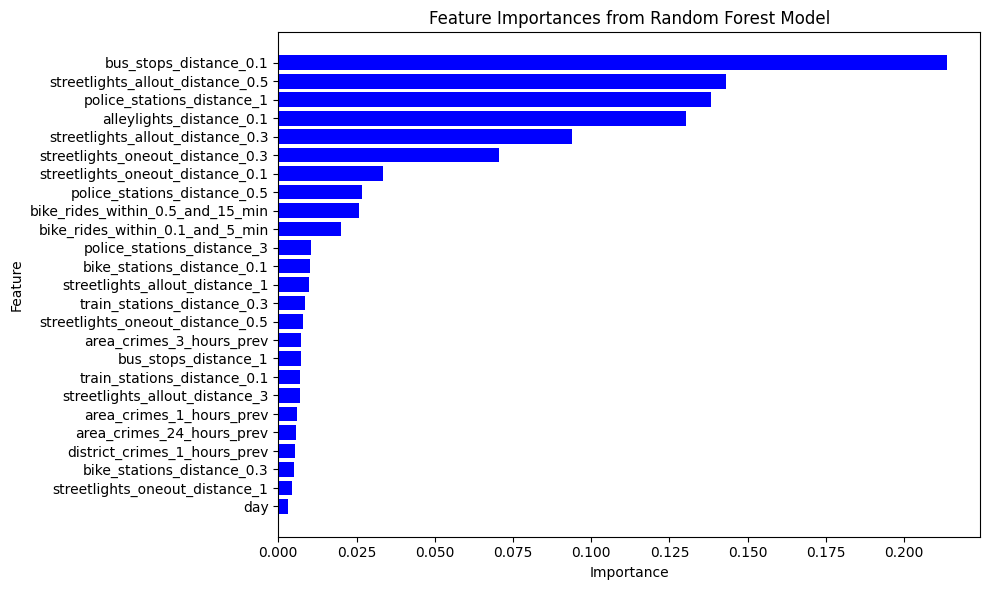

In [192]:
plt.figure(figsize=(10, 6))
plt.barh(final_district_feature_importance_df['feature'], final_district_feature_importance_df['importance'], color='b')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../results/random_forest/final_district_model_feature_importances.png')
plt.show()

In [ ]:
evaluate(final_rf_district_model, rf_district_feature_testing_selected_data, rf_district_target_testing_data)

Model Ranges
Dataset Max: 0.284404 | Dataset Min: 0.0 | Dataset Avg: 0.002071

Model Performance
RMSE: 0.0013
RMSE relative to data: 0.5%
